# Chapter 15 使用 RNNs 和 CNNs 处理序列

预测未来是你一直在做的事情，无论你是在完成一个朋友的句子，还是在期待早餐时的咖啡的味道。在本章中，我们将讨论 **循环神经网络（Recurrent Neural Networks，RNNs）** —— 一类可以预测未来的网络（嗯，在一定程度上）。RNNs 可以分析时间序列数据，比如你网站上每日活跃用户的数量，你所在城市的每小时温度，你家的每日用电量，附近汽车的轨迹，等等。一旦 RNN 学习了数据中过去的模式，它就可以利用自己的知识来预测未来，当然，假设过去的模式在未来仍然存在。

更一般的是，RNNs 可以用于任意长度的序列，而不是固定大小的输入。例如，它们可以将句子、文档或音频样本作为输入，这使得它们对于自然语言处理应用程序非常有用，如自动翻译或语音到文本。

在本章中，我们将首先介绍 RNNs 的基本概念，以及如何使用随着时间的反向传播来训练它们。然后，我们将使用它们来预测一个时间序列。在此过程中，我们将查看流行的 ARMA 的模型家族，常用于预测时间序列，并使用它们作为基线来与我们的 RNNs 进行比较。在那之后，我们将探讨 RNNs 所面临的两个主要困难：

- 不稳定的梯度（在第11章中讨论），这可以通过使用各种技术来缓解，包括 **循环辍学（recurrent dropout）** 和 **循环层归一化（recurrent layer normalization）** 。
- 有限的短期记忆，可以使用 LSTM 和 GRU 单元进行扩展。

RNNs 并不是唯一能够处理序列数据的神经网络类型。对于小的序列，一个规则的密集网络可以做到这一点，而对于非常长的序列，如音频样本或文本，卷积神经网络实际上也可以工作得很好。我们将讨论这两种可能性，并且我们将通过实现一个 WaveNet 来完成这一章 —— 一个能够处理数万个时间步长序列的 CNN 架构。我们开始吧！

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

print(tf.__version__)

2.10.0


In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## 1. 循环神经元和层（Recurrent Neurons and Layers）

到目前为止，我们一直关注的是前馈神经网络，其中的激活只在一个方向上流动，也就是从输入层到输出层。循环神经网络看起来非常像前馈神经网络，除了它也有指向后的连接。

让我们来看看最简单的 RNN，它由一个神经元接收输入、产生一个输出、并将该输出发送回自己组成，如下图所示。

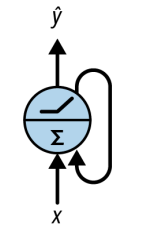

在每个 **time step** $t$（也称为 **帧**），这个循环神经元接收输入 $\pmb{x}_{(t)}$ 以及来自前一个 **time step** $\hat{y}_{(t-1)}$ 的自身输出。由于在第一个 **time step** 没有输出，它通常设置为 0 。我们可以用时间轴来表示这个很小的网络，如下图所示。

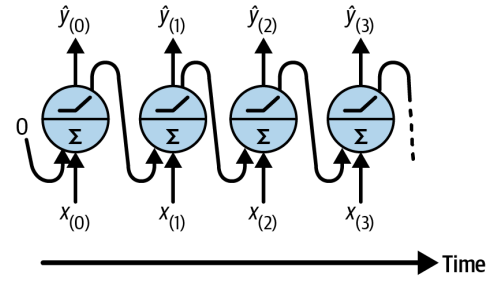

这被称为 **通过时间展开网络（unrolling the network through time）**（它是每个 **time step** 表示一次的相同的循环神经元）。

你可以很容易地创建一层循环的神经元。在每个 **time step** $t$ 中，每个神经元同时接收输入向量 $\pmb{x}_{(t)}$ 和来自前一个 **time step** $\hat{\pmb{y}}_{(t-1)}$ 的输出向量，如下图所示。

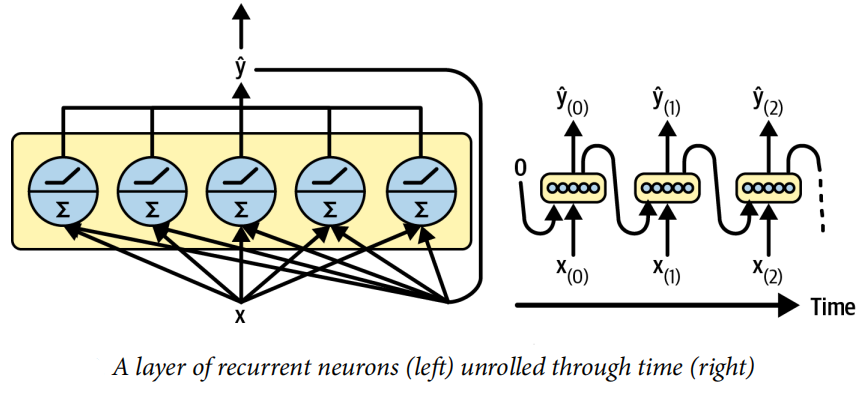

**注意**：输入和输出现在都是向量（当只有一个神经元时，输出是一个标量）。

每个循环神经元都有两组权值：一组用于输入 $\pmb{x}_{(t)}$ ，另一组用于前一个 **time step** $\hat{\pmb{y}}_{(t-1)}$ 的输出。让我们把这些权值向量称为 $\pmb{w}_x$ 和 $\pmb{w}_{\hat{y}}$ 。如果我们考虑整个循环层，而不是仅仅考虑一个循环神经元，我们就可以将所有的权值向量放在两个权值矩阵中：$\pmb{W}_x$ 和 $\pmb{W}_{\hat{y}}$ 。

然后，整个循环层的输出向量可以像你所期望的那样计算出来，如下公式所示

**循环层对于单个实例的输出**：

$$ \hat{\pmb{y}}_{(t)}=\phi(\pmb{W}_x^T\pmb{x}_{(t)}+\pmb{W}_{\hat{y}}^T\hat{\pmb{y}}_{(t-1)}+\pmb{b}) $$

其中 $\pmb{b}$ 是偏置向量，$\phi(\cdot)$ 是激活函数（例如，ReLU）。

就像前馈神经网络一样，我们可以通过将 **time step** $t$ 的所有输入放到输入矩阵 $\pmb{X}_{(t)}$ 中，为整个 mini-batch 处理一次性计算一个循环层的输出。

**在一次 pass 中所有实例的循环神经元层的输出：mini-batch**

$$ \hat{\pmb{Y}}_{(t)} = \phi(\pmb{X}_{(t)}\pmb{W}_x+\hat{\pmb{Y}}_{(t-1)}\pmb{W}_{\hat{y}}+\pmb{b})\\
= \phi([\pmb{X}_{(t)}\ \hat{\pmb{Y}}_{(t-1)}]\pmb{W}+\pmb{b})\ with \ \pmb{W} = 
\left[
\begin{matrix}
\pmb{W}_x \\
\pmb{W}_{\hat{y}} 
\end{matrix}
\right]
$$

其中，

- $\hat{\pmb{Y}}_{(t)}$ 是一个 $m\times n_{neurons}$ 的矩阵，包含 mini-batch 中每个实例在 time step $t$ 时整层的输出（$m$ 是 mini-batch 中的实例数，$n_{neurons}$ 是神经元的数量）。
- $\pmb{X}_{(t)}$ 是一个 $m\times n_{input}$ 的矩阵，包含所有实例的输入（$n_{inputs}$ 是是输入特征的数量）。
- $\pmb{W}_x$ 是一个 $n_{inputs}\times n_{neurons}$ 的矩阵，包含当前 time step 的输入的连接权重。
- $\pmb{W}_{hat{y}}$ 是一个 $n_{neurons} \times n_{neurons}$ 的矩阵，包含上一个 time step 的输出的连接权重。
- $\pmb{b}$ 是一个大小为 $n_{neurons}$ 的向量，包含每个神经元的偏差项。
- 权重矩阵 $\pmb{W}_x$ 和 $\pmb{W}_{\hat{y}}$ 通常垂直连接成一个形为 $(n_{inputs}+n_{neurons})\times n_{neurons}$ 的单一权重矩阵 $\pmb{W}$。
- 符号 $[\pmb{X}_{(t)}\hat{\pmb{Y}}_{(t-1)}]$ 表示矩阵 $\pmb{X}_{(t)}$ 和 $\hat{\pmb{Y}}_{(t-1)}$ 的水平连接。

请注意，$\pmb{Y}_{(t)}$ 是 $\pmb{X}_{(t)}$ 和 $\hat{\pmb{Y}}_{(t-1)}$ 的函数，$\hat{\pmb{Y}}_{(t-1)}$ 是 $\pmb{X}_{(t-1)}$ 和 $\hat{\pmb{Y}}_{(t-2)}$ 的函数，$\hat{\pmb{Y}}_{(t-2)}$ 是 $\pmb{X}_{(t-2)}$ 和 $\hat{\pmb{Y}}_{(t-3)}$ 的函数，以此类推。这使得 $\hat{\pmb{Y}}_{(t)}$ 成为自时间 $t=0$（即 $\pmb{X}_{(0)}$、$\pmb{X}_{(1)}$,...,$\pmb{X}_{(t)}$）以来的所有输入的函数。在第一个 time step $t=0$ 中，没有以前的输出，所以通常假设它们都为零。

### 1.1. 记忆单元（Memory Cells）

由于在 time step $t$ 处，一个循环神经元的输出是之前 time step 中所有输入的函数，所以你可以说它有一种 **记忆（memory）** 形式。神经网络的一部分在 time step 中保持某些状态被称为 **记忆单元（memory cell）**（或简称为 **单元 cell**）。

一个单个的循环神经元，或一层循环的神经元，是一个非常基本的单元，只能学习短的模式（通常大约 10 步长，但这因任务而不同）。在本章的后面，我们将看到一些更复杂、更强大的单元类型，它们能够学习更长的模式（大约是更长的10倍，但同样，这取决于任务）。

一个单元在 time step $t$ 的状态，记为 $\pmb{h}_{(t)}$（“h”代表“hidden”），是该 time step 的一些输入及其在前一个 time step 的状态的函数：$\pmb{h}_{(t)}=f(\pmb{x}_{(t)},\pmb{h}_{(t-1)})$ 。它在 time step $t$ 时的输出，表示为 $\hat{\pmb{y}}_{(t)}$ ，也是先前状态和当前输入的函数。在我们到目前为止讨论过的基本单元中，输出仅等于状态，但在更复杂的单元中，情况并非总是如此，如下图所示。

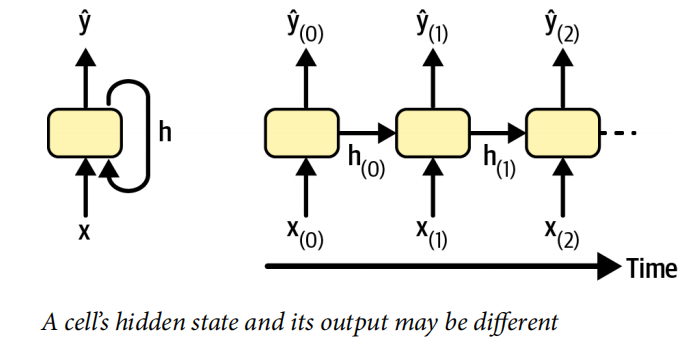

### 1.2 输入和输出序列（Input and Output Sequences）

RNN 可以同时接受一系列输入并产生一系列输出。

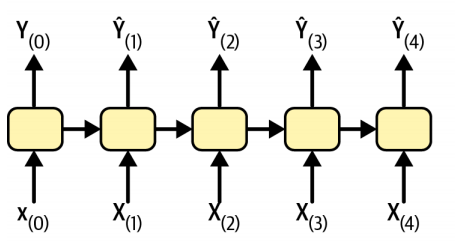

如上图所示这种类型的 **序列到序列网络（sequence-to-sequence network）** 对于预测时间序列很有用，例如您家的每日用电量：您将过去 $N$ 天的数据输入它，然后训练它输出未来偏移一天的用电量（即从 $N-1$ 天前到明天）。

或者，您可以向网络提供一系列输入并忽略除最后一个输出之外的所有输出（请参见下图中的网络）。

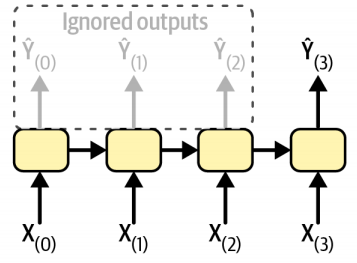

这是一个 **序列到向量（sequence-to-vector network）** 的网络。例如，您可以向网络输入与电影评论相对应的一系列单词，然后网络将输出一个情感分数（例如，从 0\[恨\] 到 1\[爱\]）。

相反，您可以在每个 time step 中反复地向网络输入相同的输入向量，并让它输出一个序列（参见下图网络）。

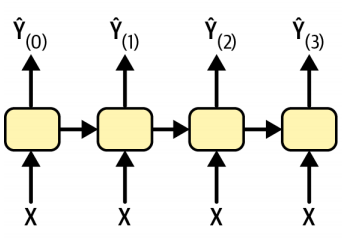

这是一个 **向量到序列（vector-to-sequence network）** 的网络。例如，输入可以是一个图像（或 CNN 的输出），而输出可以是该图像的标题。

最后，你可以有一个 **序列到向量网络（sequence-to-vector network）**，称为 **编码器（encoder）**，然后是一个 **向量到序列网络（vector-to-sequence network）**，称为 **解码器（decoder）**（见下图的网络）。

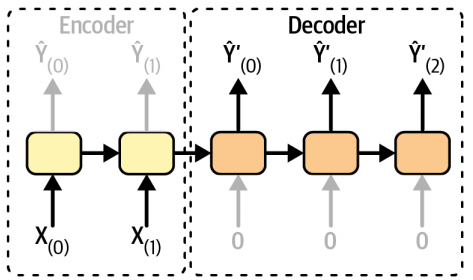

例如，这可用于将句子从一种语言翻译成另一种语言。你可以用一种语言向网络输入一个句子，编码器会将这个句子转换成一个单一的向量表示，然后解码器会将这个向量解码成另一种语言的句子。这种称为 **编码器-解码器（ encoder–decoder）** 的两步模型比尝试使用单个序列到序列 RNN 即时翻译效果要好得多：句子的最后一个词会影响翻译的第一个词，所以你需要等到你看到整个句子后再翻译。

我们将在第 16 章中介绍 编码器-解码器 的实现（正如您将看到的，它比上图所建议的要复杂一些）。

这种多功能性听起来很有希望，但是你如何训练一个循环神经网络呢？

## 2. 训练 RNNs

要训练一个RNN，诀窍是通过时间展开它（就像我们刚才做的那样），然后使用常规的反向传播，如下图。

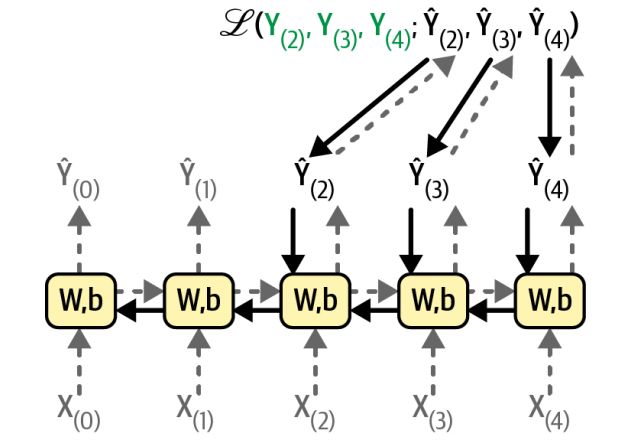

这种策略被称为 **通过时间的反向传播（backpropagation through time，BPTT）**。

就像在常规的反向传播中一样，有一个第一个向前传递通过展开的网络（由虚线箭头表示）。然后使用损失函数 $L(\pmb{Y}_{(0)},\pmb{Y}_{(1)},\cdots,\pmb{Y}_{(T)};\hat{\pmb{Y}}_{(0)}、\hat{\pmb{Y}}_{(1)},\cdots,\hat{\pmb{Y}}_{(T)})$ 评估输出序列（其中 $\pmb{Y}_{(i)}$ 是第 $i$ 个目标，$\hat{\pmb{Y}}_{(i)}$ 是第 $i$ 个预测，$T$ 是最大 time step）。

请注意，这个损失函数可能会忽略一些输出。例如，在序列到向量的 RNN 中，除了最后一个输出外，所有输出都被忽略。在上图中，仅根据最后三个输出来计算损失函数。然后，该损失函数的梯度通过展开的网络（用实心箭头表示）向后传播。在本例中，由于输出 $\hat{\pmb{Y}}_{(0)}$ 和 $\hat{\pmb{Y}}_{(1)}$ 不用于计算损失，因此梯度不会向后流过它们；它们只流过 $\hat{\pmb{Y}}_{(2)}$、 $\hat{\pmb{Y}}_{(3)}$、 $\hat{\pmb{Y}}_{(4)}$ 。

此外，由于在每个 time step 中使用相同的参数 $\pmb{W}$ 和 $\pmb{b}$ ，它们的梯度在反向传播期间将被多次调整。一旦反向阶段完成并计算出所有的梯度，BPTT 就可以执行一个梯度下降步骤来更新参数（这与常规的反向传播没有什么不同）。

幸运的是，Keras 为你处理了所有这些复杂性，你将会看到。但在我们到达那里之前，让我们加载一个时间序列，并开始使用经典的工具来分析它，以更好地理解我们正在处理什么，并获得一些 baseline 。

## 3. 预测时间序列（Forecasting a Time Series）

让我们假设你刚刚被芝加哥运输局聘为数据科学家。你的第一个任务是建立一个能够预测第二天将乘坐公交车和火车的乘客数量的模型。你可以访问自 2001 年以来的每日客流量数据。让我们一起讨论一下你将如何处理这个问题。我们将首先加载和清理数据：

In [6]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'.\\datasets\\ridership.tgz'

In [7]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

我们加载 CSV 文件，设置较短的列名，按日期对行进行排序，删除冗余的总列，并删除重复的行。现在让我们检查一下前几行是什么样子的：

In [8]:
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830


2001 年 1 月 1 日，297192 人在芝加哥登上了一辆公共汽车，126455 人登上了一列火车。`day_type` 列包含工作日的 `W`，`A` 为周六，`U` 为星期日或节假日。

In [9]:
df["2019-03":"2019-05"]

,day_type,bus,rail
date,,,
2019-03-01,W,812238,682969
2019-03-02,A,454119,349392
2019-03-03,U,313539,252150
2019-03-04,W,699086,635353
2019-03-05,W,761781,692945
...,...,...,...
2019-05-27,U,298987,256757
2019-05-28,W,769069,694292
2019-05-29,W,791059,717681


现在，让我们绘制2019年几个月的公交和铁路客流量数据，看看它是什么样子的：

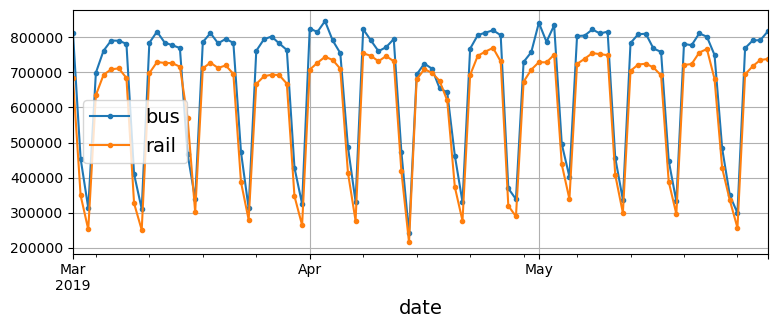

In [10]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

请注意，Pandas 在这个范围内包括了开始月和结束月，所以这绘制了从 3 月 1 日到 5 月 31 日的数据。这是一个 **时间序列（time series）** ：数据具有不同时间步长的值，通常是有规律的间隔。更具体地说，由于每个时间步长有多个值，这被称为 **多元时间序列（multivariate time series）** 。如果我们只看 `bus` 列，它将是一个单变量时间序列，每个时间步长都有一个值。预测未来的值（即预测）是处理时间序列时最典型的任务，这也是我们将在本章中关注的问题。其他任务包括 **imputation**（填充过去缺失的值）、**classification**、**anomaly detection** 等。

我们可以看到类似的模式每周都重复。这被称为每周的 **季节性（seasonality）** 。事实上，在这种情况下，它是如此的强大，以至于仅仅通过复制一周前的价值来预测明天的客流量将会产生相当不错的结果。这被称为 **朴素预测（naive forecasting）** ：简单地复制一个过去的值来做出我们的预测。朴素预测通常是一个很好的基准，在某些情况下甚至很难超越。

**注意**：一般来说，朴素预测意味着复制最新的已知值（例如，预测明天将与今天相同）。然而，在我们的例子中，由于一周中强烈的季节性，复制前一周的价值效果更好。

为了可视化这些朴素预测，让我们使用虚线覆盖两个时间序列（用于公交和铁路）以及滞后一周的同一时间序列（即向右移动）。我们还将绘制两者之间的差（即，时间 $t$ 的值减去时间 $t-7$ 的值）；这被称为 **差分（differencing）** ：

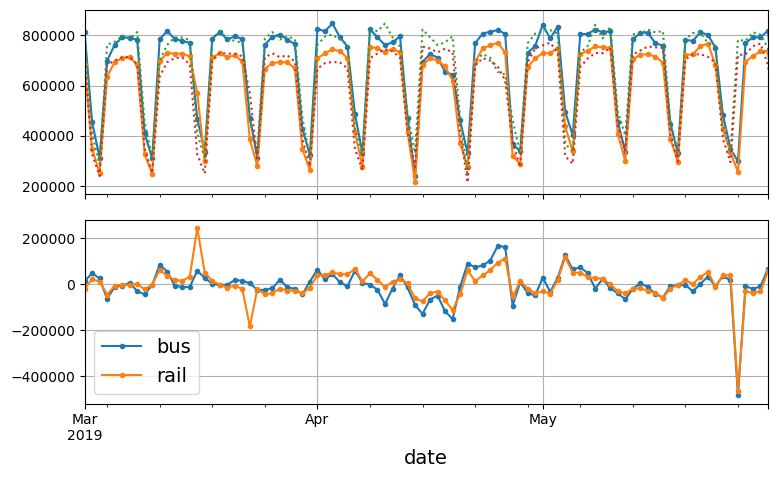

In [11]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

df.plot(ax=axs[0], legend=False, marker=".")  # original time series

df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged

diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series

axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot

save_fig("differencing_plot")  # extra code – saves the figure for the book

plt.show()

还不错！注意滞后时间序列跟踪实际时间序列的距离。当一个时间序列与它自身的滞后版本相关时，我们说这个时间序列是 **自相关（autocorrelated）** 的。正如你所看到的，除了 5 月底之外，大多数的差异都很小。也许那时有个假期？让我们检查一下 `day_type` 列：

In [12]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

事实上，当时有一个漫长的周末：星期一是 Memorial Day 的假期。我们可以用这个列来改进我们的预测，但现在让我们来衡量我们任意关注的 3 月、4 月和 2019 年 3 月和 5 月期间的平均绝对误差，以得到一个粗略的想法：

In [13]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

我们的朴素预测得到的 MAE 是大约 43916 名公交乘客和 42143 名铁路乘客。很难一眼就能看出这是多好是多坏，所以让我们通过把预测误差除以目标值来正确地看待它们：

In [14]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

我们刚刚计算的是 **平均绝对百分比误差（MAPE）**：看起来我们的初步预测给我们的 MAPE 约为 8.3% ，铁路的MAPE为 9.0% 。有趣的是，铁路预测的 MAE 看起来略好于公交预测的 MAE ，而 MAPE 则相反。这是因为公交客流量比铁路客流量要大，所以预测误差自然也要更大，但当我们把误差构建为百分比时，我们会发现公交车的预测实际上比铁路的预测略好一些。

**注意**：`MAE`、`MAPE` 和 `MSE` 是你可以用来评估预测的最常用的指标之一。和往常一样，选择正确的指标取决于任务。例如，如果您的项目遭受的大误差多于小误差，那么 `MSE` 可能会更好，因为它会强烈惩罚大错误。

看看时间序列，似乎没有任何明显的月度季节适宜性，但让我们来看看是否有任何年度的季节性。我们将查看从2001年到2019年的数据。为了减少数据窥探的风险，我们目前将忽略最近的数据。让我们还为每个序列绘制一个12个月的滚动平均值，以可视化长期趋势：

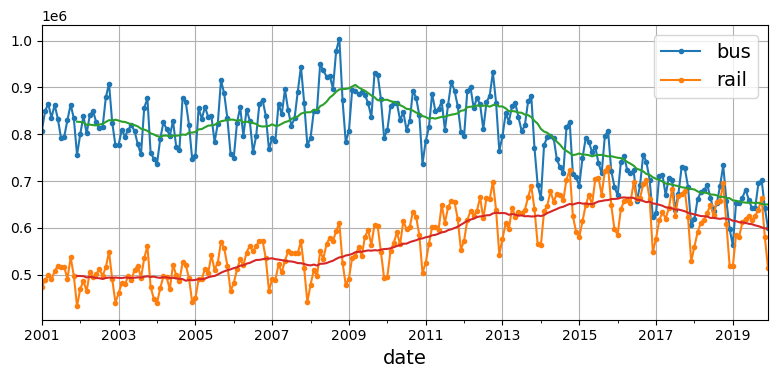

In [15]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

是的当然也有一些每年的季节性，尽管它比每周的季节性更嘈杂，而且铁路系列比公交系列更明显：我们每年在大致相同的日期看到高峰和低谷。让我们检查一下，如果我们绘制出12个月的差分，我们会得到什么：

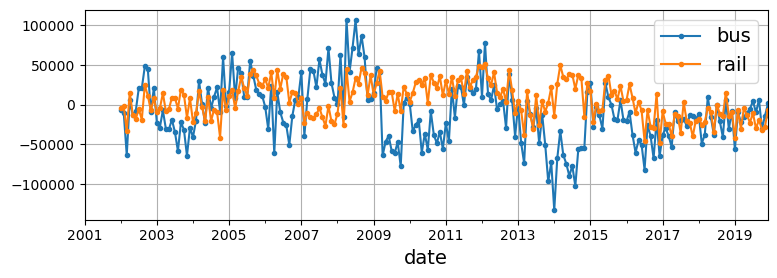

In [16]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

请注意，差分不仅消除了年度季节性，而且也消除了长期趋势。

例如，2016 年至 2019 年时间序列中的线性下降趋势在不同时间序列中成为一个大致恒定的负值。事实上，差分是一种常用的技术，用来从一个时间序列中去除趋势和季节性：研究一个固定的时间序列更容易，即它的统计特性随时间保持不变，没有任何季节性或趋势。一旦你能够对不同的时间序列做出准确的预测，就很容易把它们转化为实际时间序列的预测，只要加上以前减去的值。

你可能会认为，我们只是在试图预测明天的客流量，所以长期模式远不如短期模式重要。你是对的，但是，我们仍然可以通过考虑长期模式来略微提高业绩。

例如，2017 年 10 月，公交车的日客流量下降了约 2500 人，即每周减少了约 570 名乘客，所以如果我们在 2017 年 10 月底，通过复制上周的数字并减去 570 人来预测明天的客流量是有意义的。考虑到这一趋势，你会使你的预测平均更准确一些。

现在您已经熟悉了客流量时间序列，以及时间序列分析中一些最重要的概念，包括 **季节性（seasonality）**、**趋势（trend）**、**差分（differencing）** 和 **移动平均（moving averages）** ，让我们快速看看一个非常流行的常用于分析时间序列的统计模型家族。

### 3.1 ARMA 模型家族（The ARMA Model Family）

我们将从20世纪30年代开发的 **自回归移动平均（autoregressive moving average，ARMA）模型** 开始：它使用滞后值的简单加权计算其预测，并通过添加一个移动平均线来修正这些预测，就像我们刚才讨论的那样。

具体来说，移动平均分量是使用最后几个预测误差的加权和来计算的。如下公式显示了该模型是如何进行预测的。

**使用ARMA模型进行预测**：

$$ \hat{y}_{(t)}=\sum_{i=1}^p\alpha_iy_{(t-i)}+\sum_{i=1}^q\theta_{i}\epsilon_{(t-i)}\\ with\ \epsilon_{(t)}=y_{(t)}-\hat{y}_{(t)} $$

其中，
- $\hat{y}_{(t)}$ 是模型对 time step $t$ 的预测。
- $y_{(t)}$ 是时间序列在 time step $t$ 上的值。
- 第一个 $\sum_{i=1}^p$ 是时间序列的过去 $p$ 个值的加权和，使用学习到的权值 $\alpha_i$ 。数字 $p$ 是一个超参数，它决定了模型应该回到过去的程度。这个和是模型的自回归部分：它基于过去的值进行回归。
- 第二个 $\sum_{i=1}^q$ 是对过去 $q$ 个预测误差 $\epsilon_{(t)}$ 的加权和，使用学习到的权重 $\theta_i$ 。数字 $q$ 是一个超参数。这个和是模型的移动平均分量。

重要的是，这个模型假设时间序列是平稳的。如果不是，那么差分可能会有所帮助。在单个 time step 上使用差分将产生该时间序列的导数的近似值：实际上，它将给出该时间序列在每个时间步长上的斜率。这意味着它将消除任何线性趋势，并将其转化为一个常数值。

例如，如果您对序列 \[3,5,7,9,11\] 应用一阶差分，那么您将得到差分序列 \[2,2,2,2\]。

如果原始的时间序列是二次趋势而不是线性趋势，那么单轮的差分将是不够的。例如，序列 \[1,4,9,16,25,36\] 在一轮差分后变成 \[3,5,7,9,11\] ，但是如果您第二次运行差分，那么您将得到 \[2,2,2,2\] 。因此，运行两轮差分将消除二次趋势。

更一般地说，连续运行 $d$ 轮差分计算时间序列的 $d$ 阶导数的近似，因此它将消除多项式趋势直到 $d$ 度。这个超参数 $d$ 被称为 **整合的阶（order of integration）** 。

差分是 **自回归整合移动平均（autoregressive integrated moving average，ARIMA）模型** 的核心贡献，在1970年由 George Box 和 Gwilym Jenkins 在他们的时间序列分析中提出：这个模型运行 $d$ 轮的差异使时间序列更平稳，然后它应用常规 ARMA 模型。在进行预测时，它使用这个 ARMA 模型，然后将被差分减去的项相加。

ARMA 家族的最后一个成员是 **季节性ARIMA（seasonal ARIMA，SARIMA）模型** ：它以与 ARIMA 相同的方式建模时间序列，但它还使用完全相同的频率（例如，每周），使用完全相同的 ARIMA 方法。它总共有 7 个超参数：与 ARIMA 相同的 $p$ 、$d$ 和 $q$ 超参数，加上额外的 $P$ 、$D$ 和 $Q$ 超参数来模拟季节模式，最后是季节模式的周期，记为 $s$ 。超参数 $P$ 、$D$ 和 $Q$ 就像 $p$ 、$d$ 和 $q$ ，但它们被用来建模 $t-s$、$t-2s$、$t-3s$ 等的时间序列。

让我们看看如何将 SARIMA 模型与铁路时间序列拟合，并利用它来预测明天的客流量。我们将假装今天是 2019 年 5 月的最后一天，我们想预测 2019 年 6 月 1 日的“明天”的铁路客流量。为此，我们可以使用 **statsmodels** 库，它包含许多不同的统计模型，包括 ARMA 模型及其变体，由 **ARIMA** 类实现：

In [17]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"

rail_series = df.loc[origin:today]["rail"].asfreq("D")

model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))

model = model.fit()

y_pred = model.forecast()  # returns 427,758.6

In [18]:
y_pred[0]  # ARIMA forecast

427758.6264438537

In [19]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [20]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

在上述代码中：

- 我们首先导入 **ARIMA** 类，然后我们获取从 2019 年初到“今天”的铁路客流量数据，我们使用 `asfreq("D")` 设置该时间序列的频率为天：在这种情况下这不会改变数据，因为它已经是按天统计的，但没有这个 ARIMA 类必须猜测频率，并将显示一个警告。
- 接下来，我们创建一个 **ARIMA** 实例，传递给它直到“今天”所有的数据，我们设置模型超参数：`order=(1,0,0)` 意味着 $p=1,d=0,q=0$ ，`seasonal_order=(0,1,1,7)` 意味着 $P=0,D=1,Q=1,s=7$ 。请注意，**statsmodels** API与 Scikit-Learn 的 API 有点不同，因为我们在构建时将数据传递给模型，而不是将其传递给 fit() 方法。
- 接下来，我们拟合这个模型，并用它来预测 2019 年 6 月 1 日的“明天”。

预计有 427759 名乘客，而实际上有 379044 名乘客。哎呀，我们偏离了 12.9% ，这很糟糕。这实际上比朴素预测稍微差一些，后者的预测为 426932 人，偏离了 12.6% 。但也许那天我们只是很倒霉呢？为了验证这一点，我们可以循环运行相同的代码，对 3 月、4 月和 5 月的每天进行预测，并计算在此期间的 MAE ：

In [21]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"

time_period = pd.date_range(start_date, end_date)

rail_series = df.loc[origin:end_date]["rail"].asfreq("D")

y_preds = []

for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)

mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [22]:
mae

32040.720096033485

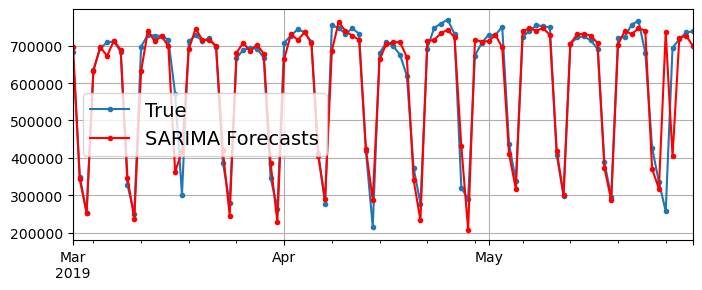

In [23]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

啊，好多了！MAE 约为 32041，明显低于我们用朴素预测得到的 MAE 42143。因此，尽管这个模型并不完美，但平均而言，它仍然大大优于朴素预测。

此时，您可能会想知道如何为 SARIMA 模型选择好的超参数。有几种方法，但最易于理解和刚刚开始的方法是蛮力方法：只需运行一个网格搜索。对于您要计算的每个模型（即，每个超参数组合），您可以运行前面的代码示例，而只更改超参数值。好的 $p$、$q$、$P$ 和 $Q$ 值通常相当小（通常是 0 到 2 ，有时是 5 或 6），$d$ 和 $D$ 通常是 0 或 1 ，有时是 2 。至于 $s$，它只是主要的季节模式的周期：在我们的例子中，它是 7 ，因为有一个强烈的每周季节性。MAE 最低的模型获胜。当然，如果其他指标更符合您的业务目标，您可以用另一个指标替换它。就这样！

**注意**：还有其他更有原则的方法来选择好的超参数，基于分析 **自相关函数（autocorrelation function，ACF）** 和 **部分自相关函数（partial autocorrelation function，PACF）**，或最小化 AIC 或 BIC 指标（第9章）惩罚使用太多参数的模型，减少了过拟合数据的风险，但网格搜索是一个很好的开始。

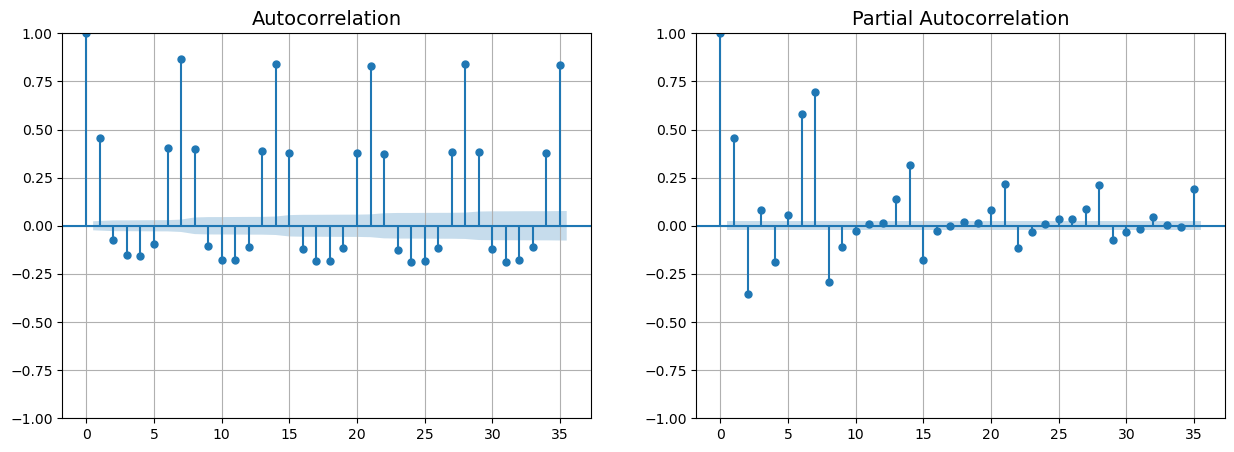

In [24]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

### 3.2 为机器学习模型准备数据（Preparing the Data for Machine Learning Models）

现在我们有了两个基线，朴素预测 和 SARIMA ，让我们尝试使用我们迄今为止所涵盖的机器学习模型来预测这个时间序列，从一个基本的线性模型开始。我们的目标是根据过去 8 周（56 天）的数据来预测明天的客流量。因此，我们的模型的输入将是序列（一旦模型进入生产阶段，通常每天只有一个序列），每个序列包含从 time step $t-55$ 到 $t$ 的56个值。对于每个输入序列，模型将输出一个单一的值：对 time step $t+1$ 的预测。

但是我们用什么来作为训练数据呢？嗯，这就是诀窍：我们将使用过去每 56 天的窗口作为训练数据，每个窗口的目标将是紧随它之后的值。

Keras 实际上有一个很好的通用函数，称为 **tf.keras.utils.timeseries_dataset_from_array()** ，帮助我们准备训练集。它以一个时间序列作为输入，并构建一个 **tf.data.Dataset** 包含了期望长度的所有窗口，以及它们相应的目标值。

这里有一个例子，采用一个包含数字 0 到 5 的时间序列，并创建一个包含所有长度为 3 的所有窗口的数据集，以及它们对应的目标值，分成 2 个批：

In [25]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]

my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)

让我们来检查一下这个数据集的内容：

In [26]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

数据集中的每个样本都是一个长度为 3 的窗口，以及它相应的目标（即窗口后面的值）。窗口分别是 \[0,1,2\]、\[1,2,3\] 和 \[2,3,4\] ，它们各自的目标值分别是 3、4 和 5 。由于总共有三个窗口，这不是批处理大小的倍数，因此最后一批处理只包含一个窗口，而不是两个窗口。

获得相同结果的另一种方法是使用 **tf.data.Dataset** 类的 **window()** 方法。它更复杂，但它给了你完全的控制，这将在本章的后面中派上用场，所以让我们看看它是如何工作的。**window()** 方法返回一个窗口数据集的数据集：

In [27]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


在这个示例中，数据集包含 6 个窗口，每个窗口比前一个窗口移动了一步，最后三个窗口更小，因为它们已经到达了系列的结尾。通常，您希望通过将 **drop_remainder=True** 传递给 **window()** 方法来去掉这些较小的窗口。

**window()** 方法返回一个嵌套的数据集，类似于列表的列表。通过调用每个窗口的 dataset 方法（例如，对它们进行洗牌或批处理它们）来进行窗口转换，这一点非常有用。然而，我们不能直接使用嵌套的数据集来进行训练，因为我们的模型将期望张量作为输入，而不是数据集。

因此，我们必须调用 **flat_map()** 方法：它将嵌套的数据集转换为 flat dataset（包含张量，而不是数据集）。

例如，假设 {1,2,3} 表示一个包含张量 1、2 和 3 的序列的数据集。如果 flat 嵌套数据集 {{1,2},{3,4,5,6}}，则得到 flat dataset {1,2,3,4,5,6}。

此外，**flat_map()** 方法将一个函数作为参数，它允许您在 flattening 之前转换嵌套数据集中的每个数据集。

例如，如果您将函数 `lambda ds: ds.batch(2)` 传递给 `flat_map()` ，那么它将把嵌套的数据集 {{1,2},{3,4,5,6}} 转换为平面数据集 {\[1,2\],\[3,4\],\[5,6\]} ：它是一个包含 3 个张量的数据集，每个张量的大小为 2 。

考虑到这一点，我们已经准备好将我们的数据集扁平化：

In [28]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))

for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


由于每个窗口数据集恰好包含四项，因此在一个窗口上调用 **batch(4)** 会产生一个大小为 4 的单一张量。我们现在有了一个包含用张量表示的连续窗口的数据集。让我们创建一个小的帮助函数，以便更容易地从数据集提取窗口：

In [29]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

最后一步是使用 **map()** 方法将每个窗口分割为输入和目标。我们还可以将生成的窗口分组为大小为 2 的批：

In [30]:
dataset = to_windows(tf.data.Dataset.range(6), 4)

dataset = dataset.map(lambda window: (window[:-1], window[-1]))

list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

正如您所看到的，我们现在有了与之前的 **timeseries_dataset_from_array()** 函数相同的输出（需要更多的努力，但很快就会是值得的）。

现在，在我们开始训练之前，我们需要将数据分成训练期、验证期和测试期。我们目前将重点关注铁路客流量。我们还将其缩小 100 万倍，以确保值接近 0-1 范围；这很好地适应了默认的初始值初始化和学习率：

In [31]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

**注意**：在处理时间序列时，您通常希望跨时间拆分。但是，在某些情况下，您可以沿着其他维度拆分，这将使您有更长的时间进行训练。例如，如果您有 10,000 家公司从 2001 年到 2019 年的财务状况数据，您可以将这些数据拆分到不同的公司。不过，这些公司中的许多公司很可能会高度相关（例如，整个经济部门可能会一起上涨或下跌），并且如果您在训练集和测试集上关联了公司，那么您的测试集将不会很有用，因为它对泛化误差的度量会存在乐观偏差。

接下来，让我们使用 **timeseries_dataset_from_array()** 来创建用于训练和验证的数据集。由于梯度下降期望训练集中的实例是 **独立同分布的（IID）**，正如我们在第4章中看到的，我们必须设置参数 **shuffle=True** 来打乱训练窗口（但不是它们的内容）：

In [32]:
seq_length = 56

tf.random.set_seed(42)  # extra code – ensures reproducibility

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

现在我们已经准备好构建和训练任何我们想要的回归模型了！

### 3.3 使用线性模型进行预测（Forecasting Using a Linear Model）

让我们先尝试一下一个基本的线性模型。我们将使用 Huber 损失，它通常比直接最小化 MAE 更好，如第10章中讨论。我们还将使用早期停止：

In [33]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

history = model.fit(train_ds, validation_data=valid_ds, 
                    epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 3s 8ms/step - loss: 0.0591 - mae: 0.2643 - val_loss: 0.0096 - val_mae: 0.1141
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0120 - mae: 0.1194 - val_loss: 0.0075 - val_mae: 0.0958
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0079 - mae: 0.0966 - val_loss: 0.0068 - val_mae: 0.0894
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0069 - mae: 0.0887 - val_loss: 0.0052 - val_mae: 0.0760
Epoch 5/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0061 - mae: 0.0824 - val_loss: 0.0049 - val_mae: 0.0727
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0063 - mae: 0.0830 - val_loss: 0.0054 - val_mae: 0.0781
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0052 - mae: 0.0741 - val_loss: 0.0047 - val_mae: 0.0701
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0054 - m

33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0466 - val_loss: 0.0021 - val_mae: 0.0374
Epoch 64/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0460 - val_loss: 0.0021 - val_mae: 0.0370
Epoch 65/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0544 - val_loss: 0.0022 - val_mae: 0.0412
Epoch 66/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0448 - val_loss: 0.0022 - val_mae: 0.0416
Epoch 67/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0482 - val_loss: 0.0021 - val_mae: 0.0383
Epoch 68/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0443 - val_loss: 0.0021 - val_mae: 0.0380
Epoch 69/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0460 - val_loss: 0.0032 - val_mae: 0.0549
Epoch 70/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0

Epoch 125/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0496 - val_loss: 0.0023 - val_mae: 0.0424
Epoch 126/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0554 - val_loss: 0.0031 - val_mae: 0.0524
Epoch 127/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0468 - val_loss: 0.0030 - val_mae: 0.0499
Epoch 128/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0494 - val_loss: 0.0023 - val_mae: 0.0420
Epoch 129/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0428 - val_loss: 0.0022 - val_mae: 0.0374
Epoch 130/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0433 - val_loss: 0.0023 - val_mae: 0.0410
Epoch 131/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0434 - val_loss: 0.0024 - val_mae: 0.0396
Epoch 132/500
33/33 [==============================] - 0s 4ms/step - 

In [34]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 9ms/step - loss: 0.0021 - mae: 0.0366


36608.58049988747

该模型的验证 MAE 约为 37,866（您的里程可能会有所不同）。这比朴素预测要好，但比SARIMA模型要差。

我们能用RNN做得更好吗？让我们来看看吧！

### 3.4 使用一个简单的 RNN 进行预测（Forecasting Using a Simple RNN）

让我们尝试一下最基本的 RNN ，它包含一个循环层，只有一个循环神经元：

In [37]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [39]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set,
                        epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [40]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 36ms/step - loss: 0.4044 - mae: 0.7300 - val_loss: 0.0761 - val_mae: 0.3499
Epoch 2/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0499 - mae: 0.2628 - val_loss: 0.0688 - val_mae: 0.3268
Epoch 3/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0481 - mae: 0.2488 - val_loss: 0.0282 - val_mae: 0.1588
Epoch 4/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0189 - mae: 0.1645 - val_loss: 0.0163 - val_mae: 0.1413
Epoch 5/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0166 - mae: 0.1569 - val_loss: 0.0160 - val_mae: 0.1413
Epoch 6/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0162 - mae: 0.1578 - val_loss: 0.0158 - val_mae: 0.1400
Epoch 7/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0160 - mae: 0.1583 - val_loss: 0.0155 - val_mae: 0.1397
Epoch 8/500
33/33 [==============================] - 1s 34ms/step - loss: 0.

33/33 [==============================] - 1s 36ms/step - loss: 0.0120 - mae: 0.1316 - val_loss: 0.0120 - val_mae: 0.1203
Epoch 63/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0119 - mae: 0.1316 - val_loss: 0.0119 - val_mae: 0.1200
Epoch 64/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0119 - mae: 0.1308 - val_loss: 0.0119 - val_mae: 0.1190
Epoch 65/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0118 - mae: 0.1305 - val_loss: 0.0118 - val_mae: 0.1195
Epoch 66/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0118 - mae: 0.1307 - val_loss: 0.0118 - val_mae: 0.1193
Epoch 67/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0118 - mae: 0.1301 - val_loss: 0.0117 - val_mae: 0.1192
Epoch 68/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0117 - mae: 0.1294 - val_loss: 0.0117 - val_mae: 0.1187
Epoch 69/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0117 

33/33 [==============================] - 1s 28ms/step - loss: 0.0104 - mae: 0.1150 - val_loss: 0.0103 - val_mae: 0.1053
Epoch 124/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0104 - mae: 0.1150 - val_loss: 0.0103 - val_mae: 0.1052
Epoch 125/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0104 - mae: 0.1153 - val_loss: 0.0103 - val_mae: 0.1050
Epoch 126/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0104 - mae: 0.1146 - val_loss: 0.0103 - val_mae: 0.1048
Epoch 127/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0104 - mae: 0.1148 - val_loss: 0.0103 - val_mae: 0.1048
Epoch 128/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0104 - mae: 0.1147 - val_loss: 0.0103 - val_mae: 0.1047
Epoch 129/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0104 - mae: 0.1147 - val_loss: 0.0103 - val_mae: 0.1046
Epoch 130/500
33/33 [==============================] - 1s 31ms/step - loss: 

33/33 [==============================] - 1s 28ms/step - loss: 0.0103 - mae: 0.1132 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 185/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0104 - mae: 0.1133 - val_loss: 0.0102 - val_mae: 0.1030
Epoch 186/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0103 - mae: 0.1131 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 187/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0103 - mae: 0.1129 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 188/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0103 - mae: 0.1132 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 189/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0103 - mae: 0.1131 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 190/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0103 - mae: 0.1132 - val_loss: 0.0102 - val_mae: 0.1030
Epoch 191/500
33/33 [==============================] - 1s 34ms/step - loss: 

33/33 [==============================] - 1s 31ms/step - loss: 0.0103 - mae: 0.1129 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 246/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0103 - mae: 0.1130 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 247/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0104 - mae: 0.1130 - val_loss: 0.0102 - val_mae: 0.1029
Epoch 248/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0104 - mae: 0.1129 - val_loss: 0.0102 - val_mae: 0.1029
Epoch 249/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0104 - mae: 0.1129 - val_loss: 0.0102 - val_mae: 0.1029
Epoch 250/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0103 - mae: 0.1130 - val_loss: 0.0102 - val_mae: 0.1029
Epoch 251/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0103 - mae: 0.1127 - val_loss: 0.0103 - val_mae: 0.1028
Epoch 252/500
33/33 [==============================] - 1s 30ms/step - loss: 

3/3 [==============================] - 0s 8ms/step - loss: 0.0103 - mae: 0.1028


102775.61098337173

Keras 中的所有循环层都期望形如 \[batch size, time steps, dimensionality\] 的三维输入，其中单变量时间序列的维数为 1 ，多变量时间序列的维数更多。回想一下，**input_shape** 参数忽略了第一个维度（即批处理大小），由于循环层可以接受任何长度的输入序列，我们可以将第二个维度设置为 None ，这意味着“任何大小”。最后，因为我们处理的是一个单变量的时间序列，所以我们需要最后一个维度的大小为 1 。这就是为什么我们指定了输入形状 \[None,1\]：它的意思是“任何长度的单变量序列”。

请注意，数据集实际上包含了形如 \[batch size, time steps\] 的输入，所以我们缺少了最后一个维度，大小是 1 的，但是Keras在这种情况下为我们添加了它。

这个模型的工作原理与我们之前看到的完全一样：初始状态 $h_{(init)}$ 被设置为 0 ，并且它被传递给单个循环神经元，以及第一个 time step 的值 $x_{(0)}$ 。神经元计算这些值加上偏差项的加权和，并将激活函数应用于结果，默认使用双曲切线函数。结果是第一个输出，$y_0$ 。在一个简单的 RNN 中，这个输出也是新的状态 $h_0$ 。这个新状态与下一个输入值 $x_{(1)}$ 一起传递到同一个循环神经元，这个过程一直重复到最后一个 time step 。最后，图层只输出最后一个值：在我们的例子中，序列是 56 步长，所以最后一个值是 $y_{55}$ 。所有这些都是同时对批处理中的每个序列执行的，在本例中中有 32 个。

**注意**：默认情况下，Keras 中的循环层只返回最终输出。要使它们每个 time step 返回一个输出，必须设置 **retern_sequences=True** ，您将看到。

这是我们的第一个循环模型！这是一个序列到向量的模型。因为有一个输出神经元，所以输出向量的大小为 1 。

现在，如果您像以前的模型一样编译、训练和评估这个模型，您会发现它根本就不好：它的验证 MAE 大于 100000！这是意料之中的，原因有二：

- 该模型只有一个循环神经元，因此它可以用来在每个 time step 进行预测的唯一数据是当前时间步长的输入值和上一个时间步长的输出值。这没什么可持续下去的！换句话说，RNN 的内存非常有限：它只是一个数字，它之前的输出。让我们计算一下这个模型有多少个参数：因为只有一个循环神经元只有两个输入值，所以整个模型只有三个参数（两个权重加上一个偏差项）。这对于这个时间序列来说还远远不够。相比之下，我们之前的模型可以同时查看所有之前的 56 个值，并且它总共有 57 个参数。
- 时间序列包含从 0 到大约 1.4 的值，但由于默认的激活函数是 tanh ，循环层只能输出在 -1 和 +1 之间的值。它不可能预测出在 1.0 到 1.4 之间的值。

让我们解决这两个问题：我们将创建一个具有更大的循环层的模型，包含 32 个循环神经元，我们将在其上添加一个密集的输出层，只有一个输出神经元，没有激活函数。循环层将能够从一个 time step 到下一个 time step 携带更多的信息，密集输出层将最终输出从 32 个维度投影到 1 维，没有任何值范围约束：

In [41]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [42]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 38ms/step - loss: 0.0420 - mae: 0.2275 - val_loss: 0.0446 - val_mae: 0.2530
Epoch 2/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0128 - mae: 0.1287 - val_loss: 0.0054 - val_mae: 0.0742
Epoch 3/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0054 - mae: 0.0762 - val_loss: 0.0025 - val_mae: 0.0525
Epoch 4/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0045 - mae: 0.0668 - val_loss: 0.0023 - val_mae: 0.0467
Epoch 5/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0043 - mae: 0.0665 - val_loss: 0.0024 - val_mae: 0.0429
Epoch 6/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0034 - mae: 0.0531 - val_loss: 0.0020 - val_mae: 0.0359
Epoch 7/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0037 - mae: 0.0586 - val_loss: 0.0026 - val_mae: 0.0437
Epoch 8/500
33/33 [==============================] - 1s 33ms/step - loss: 0.

33/33 [==============================] - 1s 31ms/step - loss: 0.0023 - mae: 0.0398 - val_loss: 0.0025 - val_mae: 0.0486
Epoch 63/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0026 - mae: 0.0455 - val_loss: 0.0018 - val_mae: 0.0318
Epoch 64/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0024 - mae: 0.0416 - val_loss: 0.0018 - val_mae: 0.0331
Epoch 65/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0024 - mae: 0.0419 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 66/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0025 - mae: 0.0413 - val_loss: 0.0021 - val_mae: 0.0366
Epoch 67/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0023 - mae: 0.0399 - val_loss: 0.0019 - val_mae: 0.0362
Epoch 68/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0024 - mae: 0.0406 - val_loss: 0.0022 - val_mae: 0.0402
Epoch 69/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0024 

28160.14364361763

现在，如果您像前一个模型一样编译、拟合和评估这个模型，您将会发现它的验证 MAE 达到了 27703 。这是迄今为止我们训练过的最好的模型，它甚至超过了 SARIMA 模型：我们做得很好！

**注意**：我们只对时间序列进行了规范化，没有去除趋势和季节性，但模型仍然表现良好。这是矛盾的，因为它可以快速搜索有前途的模型，而不用太担心预处理。但是，为了获得最佳性能，您可能需要尝试使时间序列更加平稳；例如，使用差分。

### 3.5 使用 Deep RNN 进行预测（Forecasting Using a Deep RNN）

堆叠多层单元是很常见的情况，如下图所示。

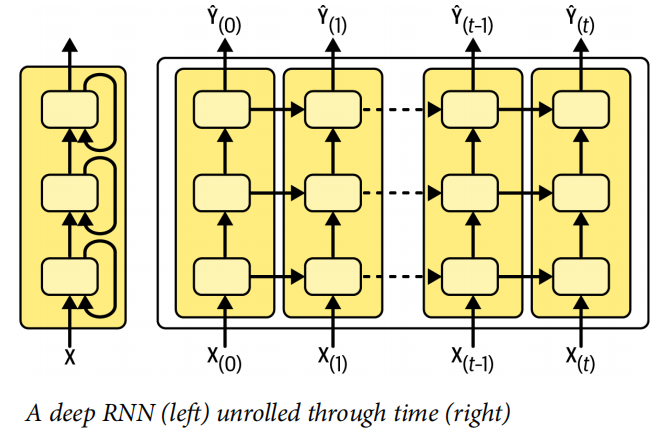

这给了你一个 **deep RNN** 。

**使用 Keras 实现一个 Deep RNN 很简单：只需堆叠循环层**。

在下面的示例中，我们使用了三个 **SimpleRNN** 层（但是我们可以使用任何其他类型的循环层，比如 **LSTM** 层或 **GRU** 层，我们将稍后讨论）。前两个是序列到序列的层，最后一个是序列到向量的层。最后，密集层生成模型的预测（您可以将它看作是向量到向量的层）。所以这个模型与上图中所示的模型一样，除了输出 $\hat{\pmb{Y}}_{(0)}$ 到 $\hat{\pmb{Y}}_{(t-1)}$ 被忽略，并且在 $\hat{\pmb{Y}}_{(t)}$ 的顶部有一个密集层，它输出实际的预测：

In [43]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

**注意**：确保为所有循环层设置 **return_sequences=True** （除最后一个层之外，如果您只关心最后一个输出）。如果忘记为一个循环层设置此参数，它将输出一个只包含最后一个 time step 输出的 2D 数组，而不是一个包含所有 time step 输出的 3D 数组。下一个循环层将反馈您没有以预期的 3D 格式提供它的序列。

In [44]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 6s 119ms/step - loss: 0.0309 - mae: 0.1980 - val_loss: 0.0178 - val_mae: 0.1309
Epoch 2/500
33/33 [==============================] - 4s 113ms/step - loss: 0.0164 - mae: 0.1549 - val_loss: 0.0133 - val_mae: 0.1378
Epoch 3/500
33/33 [==============================] - 4s 114ms/step - loss: 0.0143 - mae: 0.1418 - val_loss: 0.0112 - val_mae: 0.1403
Epoch 4/500
33/33 [==============================] - 4s 117ms/step - loss: 0.0085 - mae: 0.1025 - val_loss: 0.0044 - val_mae: 0.0719
Epoch 5/500
33/33 [==============================] - 4s 111ms/step - loss: 0.0053 - mae: 0.0710 - val_loss: 0.0032 - val_mae: 0.0573
Epoch 6/500
33/33 [==============================] - 4s 106ms/step - loss: 0.0049 - mae: 0.0681 - val_loss: 0.0030 - val_mae: 0.0533
Epoch 7/500
33/33 [==============================] - 4s 114ms/step - loss: 0.0044 - mae: 0.0611 - val_loss: 0.0049 - val_mae: 0.0794
Epoch 8/500
33/33 [==============================] - 4s 108ms/step - 

33/33 [==============================] - 3s 101ms/step - loss: 0.0029 - mae: 0.0477 - val_loss: 0.0022 - val_mae: 0.0393
Epoch 63/500
33/33 [==============================] - 3s 102ms/step - loss: 0.0029 - mae: 0.0489 - val_loss: 0.0018 - val_mae: 0.0315
Epoch 64/500
33/33 [==============================] - 4s 109ms/step - loss: 0.0026 - mae: 0.0442 - val_loss: 0.0024 - val_mae: 0.0462
Epoch 65/500
33/33 [==============================] - 4s 109ms/step - loss: 0.0027 - mae: 0.0455 - val_loss: 0.0028 - val_mae: 0.0515
Epoch 66/500
33/33 [==============================] - 4s 113ms/step - loss: 0.0028 - mae: 0.0457 - val_loss: 0.0020 - val_mae: 0.0367
Epoch 67/500
33/33 [==============================] - 4s 111ms/step - loss: 0.0027 - mae: 0.0451 - val_loss: 0.0018 - val_mae: 0.0326
Epoch 68/500
33/33 [==============================] - 4s 109ms/step - loss: 0.0029 - mae: 0.0480 - val_loss: 0.0024 - val_mae: 0.0448
Epoch 69/500
33/33 [==============================] - 4s 120ms/step - loss:

31420.987099409103

如果你训练和评估这个模型，你会发现它的 MAE 约为 31211 。这比两个基线都好，但它没有超过我们的更浅的 RNN 。看起来这个 RNN 对于我们的任务来说有点太大了。

### 3.6 多元时间序列的预测（Forecasting Multivariate Time Series）

神经网络的一个巨大特性是它们的灵活性：特别是，它们可以处理多元时间序列，而几乎不改变它们的结构。例如，让我们尝试使用公交车和铁路数据作为输入来预测铁路时间序列。事实上，让我们也加入这一天的类型吧！因为我们总是可以提前知道明天是工作日、周末还是假日，所以我们可以把一天的类型系列转移到未来，这样模型就以明天的类型作为输入。为简单起见，我们将使用 Pandas 进行此处理：

In [50]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input

df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type

df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

现在 **df_mulvar** 是一个有五列的 DataFrame ：公交车和铁路数据，加上三列包含第二天类型的独热编码（回想一下，有三种可能的一天类型，W、A 和 U）。接下来，我们可以像之前那样继续前进。首先，我们将数据分成三个阶段，分别进行培训、验证和测试：

In [51]:
df_mulvar

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0
...,...,...,...,...,...
2021-11-26,0.257700,0.189694,1,0,0
2021-11-27,0.237839,0.187065,0,1,0
2021-11-28,0.184817,0.147830,0,0,1


In [52]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

然后，我们创建了这些数据集：

In [53]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

最后，我们创建 RNN ：

In [55]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

请注意，与我们之前构建的 `univar_model` RNN 的唯一区别是输入形状：在每个时间步长中，模型现在接收到 5 个输入，而不是一个。该模型实际上达到了 22062 的验证 MAE 。现在我们已经取得了巨大的进步！

In [56]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 40ms/step - loss: 0.0106 - mae: 0.1042 - val_loss: 0.0018 - val_mae: 0.0518
Epoch 2/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0016 - mae: 0.0408 - val_loss: 0.0017 - val_mae: 0.0509
Epoch 3/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0014 - mae: 0.0372 - val_loss: 0.0011 - val_mae: 0.0378
Epoch 4/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0015 - mae: 0.0393 - val_loss: 8.9520e-04 - val_mae: 0.0327
Epoch 5/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0013 - mae: 0.0347 - val_loss: 7.7333e-04 - val_mae: 0.0278
Epoch 6/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0014 - mae: 0.0381 - val_loss: 0.0014 - val_mae: 0.0452
Epoch 7/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0014 - mae: 0.0380 - val_loss: 6.6502e-04 - val_mae: 0.0251
Epoch 8/500
33/33 [==============================] - 1s 30ms/ste

33/33 [==============================] - 1s 28ms/step - loss: 0.0011 - mae: 0.0323 - val_loss: 7.0497e-04 - val_mae: 0.0270
Epoch 62/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0012 - mae: 0.0363 - val_loss: 0.0015 - val_mae: 0.0462
Epoch 63/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0013 - mae: 0.0354 - val_loss: 8.0226e-04 - val_mae: 0.0296
Epoch 64/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0010 - mae: 0.0302 - val_loss: 0.0011 - val_mae: 0.0388
Epoch 65/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0011 - mae: 0.0327 - val_loss: 6.1852e-04 - val_mae: 0.0230
Epoch 66/500
33/33 [==============================] - 1s 27ms/step - loss: 9.7262e-04 - mae: 0.0289 - val_loss: 8.0499e-04 - val_mae: 0.0308
Epoch 67/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0014 - mae: 0.0384 - val_loss: 0.0012 - val_mae: 0.0413
Epoch 68/500
33/33 [==============================] - 1s 31ms/

33/33 [==============================] - 1s 29ms/step - loss: 9.2498e-04 - mae: 0.0290 - val_loss: 0.0010 - val_mae: 0.0358
Epoch 121/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0010 - mae: 0.0315 - val_loss: 9.0198e-04 - val_mae: 0.0318
Epoch 122/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0010 - mae: 0.0312 - val_loss: 0.0011 - val_mae: 0.0373
Epoch 123/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0013 - mae: 0.0377 - val_loss: 5.9893e-04 - val_mae: 0.0229
Epoch 124/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0014 - mae: 0.0393 - val_loss: 6.3219e-04 - val_mae: 0.0232
Epoch 125/500
33/33 [==============================] - 1s 29ms/step - loss: 9.5005e-04 - mae: 0.0297 - val_loss: 6.8502e-04 - val_mae: 0.0254
Epoch 126/500
33/33 [==============================] - 1s 31ms/step - loss: 9.3950e-04 - mae: 0.0289 - val_loss: 6.9617e-04 - val_mae: 0.0257
Epoch 127/500
33/33 [=======================

22043.93409192562

事实上，让 RNN 预测公交和铁路的情况并不难。在创建数据集时，您只需要更改目标，将训练集设置为 `mulvar_train[["bus","rail"]][seq_length:]` ，将验证集设置为 `mulvar_valid[["bus","rail"]][seq_length:]` 。你必须在输出密集层中增加一个额外的神经元，因为它现在必须做出两个预测：一个是明天的公交客流量，另一个是铁路。仅此而已！

In [57]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 41ms/step - loss: 0.0213 - mae: 0.1411 - val_loss: 0.0036 - val_mae: 0.0694
Epoch 2/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0037 - mae: 0.0597 - val_loss: 0.0024 - val_mae: 0.0521
Epoch 3/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0031 - mae: 0.0525 - val_loss: 0.0014 - val_mae: 0.0370
Epoch 4/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0027 - mae: 0.0504 - val_loss: 0.0023 - val_mae: 0.0540
Epoch 5/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0026 - mae: 0.0496 - val_loss: 0.0012 - val_mae: 0.0353
Epoch 6/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0025 - mae: 0.0479 - val_loss: 0.0014 - val_mae: 0.0402
Epoch 7/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0024 - mae: 0.0483 - val_loss: 0.0011 - val_mae: 0.0337
Epoch 8/500
33/33 [==============================] - 1s 32ms/step - loss: 0.

33/33 [==============================] - 1s 26ms/step - loss: 0.0011 - mae: 0.0335 - val_loss: 7.7453e-04 - val_mae: 0.0300
Epoch 62/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0011 - mae: 0.0333 - val_loss: 7.7827e-04 - val_mae: 0.0300
Epoch 63/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0011 - mae: 0.0333 - val_loss: 7.6278e-04 - val_mae: 0.0294
Epoch 64/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0012 - mae: 0.0336 - val_loss: 0.0010 - val_mae: 0.0356
Epoch 65/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0012 - mae: 0.0355 - val_loss: 8.2284e-04 - val_mae: 0.0303
Epoch 66/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0011 - mae: 0.0333 - val_loss: 7.9709e-04 - val_mae: 0.0297
Epoch 67/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0011 - mae: 0.0334 - val_loss: 7.1731e-04 - val_mae: 0.0282
Epoch 68/500
33/33 [==============================] - 1s 2

Epoch 121/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0011 - mae: 0.0327 - val_loss: 7.2169e-04 - val_mae: 0.0282
Epoch 122/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0011 - mae: 0.0317 - val_loss: 7.9374e-04 - val_mae: 0.0299
Epoch 123/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0011 - mae: 0.0325 - val_loss: 7.3874e-04 - val_mae: 0.0285
Epoch 124/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0011 - mae: 0.0327 - val_loss: 7.0194e-04 - val_mae: 0.0276
Epoch 125/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0011 - mae: 0.0327 - val_loss: 7.9718e-04 - val_mae: 0.0304
Epoch 126/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0011 - mae: 0.0320 - val_loss: 7.2797e-04 - val_mae: 0.0284
Epoch 127/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0011 - mae: 0.0328 - val_loss: 0.0012 - val_mae: 0.0404
Epoch 128/500
33/33 [=================

33/33 [==============================] - 1s 33ms/step - loss: 0.0011 - mae: 0.0324 - val_loss: 9.5965e-04 - val_mae: 0.0345
Epoch 181/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0010 - mae: 0.0314 - val_loss: 7.4867e-04 - val_mae: 0.0290
Epoch 182/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0011 - mae: 0.0322 - val_loss: 7.5015e-04 - val_mae: 0.0288
Epoch 183/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0010 - mae: 0.0315 - val_loss: 7.2465e-04 - val_mae: 0.0283
Epoch 184/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0010 - mae: 0.0309 - val_loss: 7.2668e-04 - val_mae: 0.0283
Epoch 185/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0010 - mae: 0.0314 - val_loss: 6.9186e-04 - val_mae: 0.0270
Epoch 186/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0010 - mae: 0.0311 - val_loss: 7.1497e-04 - val_mae: 0.0279
Epoch 187/500
33/33 [===========================

33/33 [==============================] - 1s 29ms/step - loss: 9.8811e-04 - mae: 0.0307 - val_loss: 6.9605e-04 - val_mae: 0.0272
Epoch 240/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0010 - mae: 0.0317 - val_loss: 6.9917e-04 - val_mae: 0.0272
Epoch 241/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0011 - mae: 0.0320 - val_loss: 7.6813e-04 - val_mae: 0.0292
Epoch 242/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0010 - mae: 0.0311 - val_loss: 6.7129e-04 - val_mae: 0.0263
Epoch 243/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0010 - mae: 0.0312 - val_loss: 6.8470e-04 - val_mae: 0.0264
Epoch 244/500
33/33 [==============================] - 1s 26ms/step - loss: 9.9096e-04 - mae: 0.0304 - val_loss: 6.7497e-04 - val_mae: 0.0263
Epoch 245/500
33/33 [==============================] - 1s 27ms/step - loss: 9.9730e-04 - mae: 0.0308 - val_loss: 6.7580e-04 - val_mae: 0.0269
Epoch 246/500
33/33 [===============

33/33 [==============================] - 1s 31ms/step - loss: 9.8007e-04 - mae: 0.0301 - val_loss: 7.2211e-04 - val_mae: 0.0276
Epoch 298/500
33/33 [==============================] - 1s 30ms/step - loss: 9.7374e-04 - mae: 0.0302 - val_loss: 6.5314e-04 - val_mae: 0.0258
Epoch 299/500
33/33 [==============================] - 1s 31ms/step - loss: 9.7252e-04 - mae: 0.0301 - val_loss: 6.4206e-04 - val_mae: 0.0254
Epoch 300/500
33/33 [==============================] - 1s 31ms/step - loss: 9.9709e-04 - mae: 0.0310 - val_loss: 7.3510e-04 - val_mae: 0.0283
Epoch 301/500
33/33 [==============================] - 1s 30ms/step - loss: 9.5252e-04 - mae: 0.0296 - val_loss: 6.8059e-04 - val_mae: 0.0266
Epoch 302/500
33/33 [==============================] - 1s 31ms/step - loss: 9.5780e-04 - mae: 0.0301 - val_loss: 6.6327e-04 - val_mae: 0.0262
Epoch 303/500
33/33 [==============================] - 1s 31ms/step - loss: 9.6565e-04 - mae: 0.0302 - val_loss: 6.7382e-04 - val_mae: 0.0265
Epoch 304/500
33/33 

25398.23018014431

正如我们在第 10 章中讨论的那样，对多个相关任务使用单个模型通常会比对每个任务使用单独的模型产生更好的性能，因为为一个任务学习的特征可能对其他任务有用，而且还因为必须表现良好 跨多个任务防止模型过度拟合（这是一种正则化形式）。 然而，这取决于任务，在这种特殊情况下，预测公共汽车和铁路客运量的多任务 RNN 的表现不如预测其中一个或另一个的专用模型（使用所有五列作为输入）。尽管如此，它达到了铁路 25,330 和公共汽车 26,369 的验证 MAE，这非常好。

In [58]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894737

In [59]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)

for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 11ms/step
bus 25819
rail 24976


### 3.7 预测未来的几个 time step（Forecasting Several Time Steps Ahead）

到目前为止，我们只预测了下一个 time step 的值，但我们可以通过适当地更改目标来轻松预测提前几步的值（例如，要预测 2 周后的乘客量，我们可以只更改目标成为提前 14 天而不是提前 1 天的值）。但是如果我们想预测接下来的 14 个值呢？

第一种选择是采用我们之前为铁路时间序列训练的 `univar_model` RNN ，让它预测下一个值，并将该值添加到输入中，就好像预测值实际上已经发生了一样；然后，我们将再次使用该模型来预测以下值，以此类推，如下代码所示：

In [61]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 24ms/step


在这段代码中，我们取验证期的前 56 天的铁路客流量，并将数据转换为形状为 \[1,56,1\] 的 NumPy 数组（回想一下，循环层期望 3D 输入）。然后，我们反复使用该模型来预测下一个值，并沿着时间轴（`axis=1`）将每个预测附加到输入序列中。所得到的预测结果如下图所示。

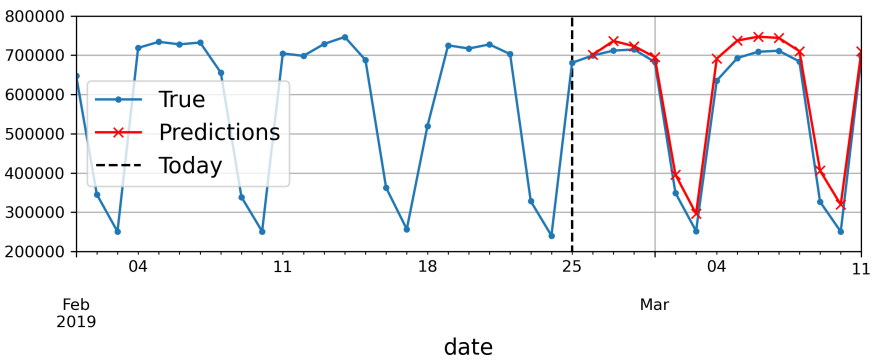

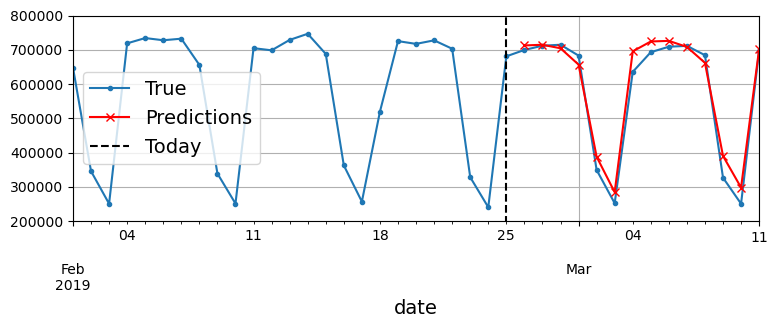

In [62]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

第二种选择是训练一个 RNN 来一次预测接下来的 14 个值。我们仍然可以使用序列到向量的模型，但它将输出 14 个值，而不是 1 个值。然而，我们首先需要将目标更改为包含接下来 14 个值的向量。为了做到这一点，我们可以再次使用 `timeseries_dataset_from_array()` ，但这一次要求它创建没有目标（`targets=None`）和更长的序列，长度为 `seq_length+14` 。然后，我们可以使用数据集的 `map()` 方法，将每批序列应用一个自定义函数，并将它们分成输入和目标。

在这个例子中，我们使用多元时间序列作为输入（使用所有五列），并预测未来 14 天的铁路客流量：

In [63]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

现在我们只需要在输出层上有 14 个单元，而不是 1 个：

In [65]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [66]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 39ms/step - loss: 0.0620 - mae: 0.2681 - val_loss: 0.0236 - val_mae: 0.1704
Epoch 2/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0197 - mae: 0.1608 - val_loss: 0.0154 - val_mae: 0.1327
Epoch 3/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0151 - mae: 0.1402 - val_loss: 0.0123 - val_mae: 0.1208
Epoch 4/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0128 - mae: 0.1273 - val_loss: 0.0104 - val_mae: 0.1111
Epoch 5/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0113 - mae: 0.1183 - val_loss: 0.0091 - val_mae: 0.1050
Epoch 6/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0102 - mae: 0.1109 - val_loss: 0.0079 - val_mae: 0.0978
Epoch 7/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0093 - mae: 0.1049 - val_loss: 0.0071 - val_mae: 0.0935
Epoch 8/500
33/33 [==============================] - 1s 34ms/step - loss: 0.

33/33 [==============================] - 1s 28ms/step - loss: 0.0037 - mae: 0.0539 - val_loss: 0.0018 - val_mae: 0.0440
Epoch 63/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0037 - mae: 0.0531 - val_loss: 0.0017 - val_mae: 0.0419
Epoch 64/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0037 - mae: 0.0532 - val_loss: 0.0017 - val_mae: 0.0427
Epoch 65/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0036 - mae: 0.0529 - val_loss: 0.0018 - val_mae: 0.0431
Epoch 66/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0036 - mae: 0.0526 - val_loss: 0.0016 - val_mae: 0.0403
Epoch 67/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0037 - mae: 0.0547 - val_loss: 0.0018 - val_mae: 0.0430
Epoch 68/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0036 - mae: 0.0530 - val_loss: 0.0017 - val_mae: 0.0425
Epoch 69/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0037 

33/33 [==============================] - 1s 31ms/step - loss: 0.0032 - mae: 0.0480 - val_loss: 0.0015 - val_mae: 0.0375
Epoch 124/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0033 - mae: 0.0485 - val_loss: 0.0018 - val_mae: 0.0427
Epoch 125/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0032 - mae: 0.0485 - val_loss: 0.0015 - val_mae: 0.0381
Epoch 126/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0032 - mae: 0.0480 - val_loss: 0.0015 - val_mae: 0.0367
Epoch 127/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0032 - mae: 0.0477 - val_loss: 0.0015 - val_mae: 0.0373
Epoch 128/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0032 - mae: 0.0477 - val_loss: 0.0014 - val_mae: 0.0367
Epoch 129/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0032 - mae: 0.0481 - val_loss: 0.0015 - val_mae: 0.0371
Epoch 130/500
33/33 [==============================] - 1s 33ms/step - loss: 

33/33 [==============================] - 1s 27ms/step - loss: 0.0030 - mae: 0.0462 - val_loss: 0.0014 - val_mae: 0.0356
Epoch 185/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0030 - mae: 0.0456 - val_loss: 0.0014 - val_mae: 0.0350
Epoch 186/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0031 - mae: 0.0464 - val_loss: 0.0014 - val_mae: 0.0349
Epoch 187/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0031 - mae: 0.0470 - val_loss: 0.0014 - val_mae: 0.0348
Epoch 188/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0031 - mae: 0.0458 - val_loss: 0.0014 - val_mae: 0.0350
Epoch 189/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0031 - mae: 0.0470 - val_loss: 0.0015 - val_mae: 0.0362
Epoch 190/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0031 - mae: 0.0462 - val_loss: 0.0015 - val_mae: 0.0364
Epoch 191/500
33/33 [==============================] - 1s 26ms/step - loss: 

33/33 [==============================] - 1s 30ms/step - loss: 0.0029 - mae: 0.0450 - val_loss: 0.0015 - val_mae: 0.0363
Epoch 246/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0030 - mae: 0.0455 - val_loss: 0.0014 - val_mae: 0.0350
Epoch 247/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0030 - mae: 0.0454 - val_loss: 0.0014 - val_mae: 0.0350
Epoch 248/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0030 - mae: 0.0457 - val_loss: 0.0014 - val_mae: 0.0347
Epoch 249/500
33/33 [==============================] - 1s 28ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0014 - val_mae: 0.0345
Epoch 250/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0030 - mae: 0.0453 - val_loss: 0.0014 - val_mae: 0.0347
Epoch 251/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0014 - val_mae: 0.0354
Epoch 252/500
33/33 [==============================] - 1s 30ms/step - loss: 

3/3 [==============================] - 0s 7ms/step - loss: 0.0014 - mae: 0.0344


34376.31204724312

在训练这个模型后，您可以一次性预测接下来的 14 个值：

In [68]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

Y_pred

1/1 [==============================] - 0s 24ms/step


array([[0.71614575, 0.7094024 , 0.70486856, 0.66593325, 0.37225097,
        0.27248752, 0.6687218 , 0.6990717 , 0.7477151 , 0.72547805,
        0.69063896, 0.38361475, 0.2741105 , 0.66767097]], dtype=float32)

这种方法工作得很好。它对第二天的预测明显好于对未来14天的预测，但它不会像之前的方法那样积累错误。然而，我们仍然可以做得更好，使用序列到序列（或seq2seq）模型。

### 3.8 使用从序列到序列的模型进行预测（Forecasting Using a Sequence-to-Sequence Model）

与其训练模型仅在最后一个 time step 预测接下来的 14 个值，我们可以训练它在每个时间步预测接下来的 14 个值。换句话说，我们可以把这个 sequence-to-vector RNN变成 sequence-to-sequence RNN。这种技术的优点是损失将包含 RNN 在每个 time step 的输出项，而不仅仅是最后一个 time step 的输出。

这意味着将有更多的误差梯度流过模型，并且它们不必在时间中流动那么多，因为它们将来自每个 time step 的输出，而不仅仅是最后一个。 这将既稳定又加速训练。

需要明确的是，在 time step 0 模型将输出一个向量，其中包含 time step 1 到 14 的预测，然后在 time step 1，模型将预测 time step 2 到 15，依此类推。换句话说，目标是连续窗口的序列，在每个 time step 移动一个 time step 。目标不再是一个向量，而是一个与输入长度相同的序列，每一步都包含一个 14 维向量。

准备数据集并不简单，因为每个实例都有一个窗口作为输入，并有一个窗口序列作为输出。一种方法是使用我们之前创建的 **to_windows()** 实用程序函数，连续两次，以获得连续窗口的窗口。

例如，让我们将数字 0 到 6 的序列转换为一个包含 4 个连续窗口序列的数据集，每个窗口的长度为 3 ：

In [69]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

现在我们可以使用 `map()` 方法将这些窗口分割为输入和目标：

In [70]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

现在数据集包含长度为 4 的序列作为输入，目标是包含每个 time step 的接下来两个 step 的序列。例如，第一个输入序列是 \[0, 1, 2, 3\] ，它对应的目标是 \[\[1, 2\], \[2, 3\], \[3, 4\], \[4, 5\]\] ，即 是每个 time step 的下两个值。如果你像我一样，你可能需要几分钟来思考这个问题。慢慢来！

**注意**：令人惊讶的是，目标包含出现在输入中的值。那不是作弊吗？ 幸运的是，一点也不：在每个 time step ，RNN 只知道过去的 time step ；它不能向前看。也就是说这是一个因果模型。

让我们创建另一个小实用函数来为我们的序列到序列模型准备数据集。它还将处理洗牌（可选）和批处理：

In [71]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

现在我们可以使用这个函数来创建数据集：

In [72]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)

seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

最后，我们可以建立序列到序列的模型：

In [73]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

它与我们之前的模型几乎相同：**唯一的区别** 是我们在 **SimpleRNN** 层中设置了 **return_sequences=True** 。这样，它将输出一系列向量（每个大小为 32），而不是在最后一个 time step 输出单个向量。 **Dense** 层足够智能，可以将序列作为输入处理：它将在每个 time step 应用，将 32 维向量作为输入并输出 14 维向量。事实上，另一种获得完全相同结果的方法是使用内核大小为 1 的 **Conv1D** 层：**Conv1D(14, kernel_size=1)** 。

**注意**：Keras 提供了一个 **TimeDistributed** 层，可让您在每个 time step 将任何向量到向量层应用于输入序列中的每个向量。它通过重塑输入使每个 time step 都被视为一个单独的实例来有效地做到这一点，然后它重塑整层的输出以恢复时间维度。在我们的例子中，我们不需要它，因为密集层已经支持序列作为输入。

训练代码和平时一样。在训练过程中，模型的所有输出都会被使用，但训练后只有最后一个时间步的输出很重要，其余的都可以忽略。例如，我们可以这样预测未来 14 天的铁路客运量：

In [74]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 4s 86ms/step - loss: 0.0602 - mae: 0.2534 - val_loss: 0.0159 - val_mae: 0.1364
Epoch 2/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0094 - mae: 0.1005 - val_loss: 0.0069 - val_mae: 0.0828
Epoch 3/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0064 - mae: 0.0793 - val_loss: 0.0060 - val_mae: 0.0754
Epoch 4/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0055 - mae: 0.0712 - val_loss: 0.0054 - val_mae: 0.0692
Epoch 5/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0050 - mae: 0.0665 - val_loss: 0.0049 - val_mae: 0.0641
Epoch 6/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0048 - mae: 0.0641 - val_loss: 0.0050 - val_mae: 0.0657
Epoch 7/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0045 - mae: 0.0616 - val_loss: 0.0046 - val_mae: 0.0608
Epoch 8/500
33/33 [==============================] - 1s 41ms/step - loss: 0.

33/33 [==============================] - 1s 37ms/step - loss: 0.0033 - mae: 0.0497 - val_loss: 0.0037 - val_mae: 0.0505
Epoch 63/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0034 - mae: 0.0505 - val_loss: 0.0036 - val_mae: 0.0479
Epoch 64/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0033 - mae: 0.0491 - val_loss: 0.0037 - val_mae: 0.0483
Epoch 65/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0033 - mae: 0.0488 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 66/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0033 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0480
Epoch 67/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0033 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0481
Epoch 68/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0033 - mae: 0.0488 - val_loss: 0.0036 - val_mae: 0.0481
Epoch 69/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0033 

33/33 [==============================] - 1s 38ms/step - loss: 0.0032 - mae: 0.0473 - val_loss: 0.0037 - val_mae: 0.0479
Epoch 124/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0032 - mae: 0.0476 - val_loss: 0.0037 - val_mae: 0.0481
Epoch 125/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0032 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0479
Epoch 126/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0031 - mae: 0.0470 - val_loss: 0.0036 - val_mae: 0.0481
Epoch 127/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0032 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0478
Epoch 128/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0032 - mae: 0.0480 - val_loss: 0.0036 - val_mae: 0.0477
Epoch 129/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0032 - mae: 0.0484 - val_loss: 0.0037 - val_mae: 0.0500
Epoch 130/500
33/33 [==============================] - 1s 39ms/step - loss: 

33/33 [==============================] - 1s 42ms/step - loss: 0.0031 - mae: 0.0465 - val_loss: 0.0036 - val_mae: 0.0478
Epoch 185/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0031 - mae: 0.0465 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 186/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0031 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0475
Epoch 187/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0031 - mae: 0.0465 - val_loss: 0.0036 - val_mae: 0.0475
Epoch 188/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0031 - mae: 0.0464 - val_loss: 0.0036 - val_mae: 0.0475
Epoch 189/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0031 - mae: 0.0465 - val_loss: 0.0036 - val_mae: 0.0475
Epoch 190/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0031 - mae: 0.0463 - val_loss: 0.0036 - val_mae: 0.0477
Epoch 191/500
33/33 [==============================] - 1s 36ms/step - loss: 

33/33 [==============================] - 1s 37ms/step - loss: 0.0031 - mae: 0.0469 - val_loss: 0.0036 - val_mae: 0.0472
Epoch 246/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0031 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0471
Epoch 247/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0031 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0472
Epoch 248/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - mae: 0.0461 - val_loss: 0.0036 - val_mae: 0.0471
Epoch 249/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0030 - mae: 0.0463 - val_loss: 0.0036 - val_mae: 0.0470
Epoch 250/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0030 - mae: 0.0462 - val_loss: 0.0035 - val_mae: 0.0470
Epoch 251/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0036 - val_mae: 0.0478
Epoch 252/500
33/33 [==============================] - 1s 37ms/step - loss: 

33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - mae: 0.0457 - val_loss: 0.0035 - val_mae: 0.0469
Epoch 307/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0035 - val_mae: 0.0468
Epoch 308/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0030 - mae: 0.0457 - val_loss: 0.0035 - val_mae: 0.0472
Epoch 309/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0030 - mae: 0.0458 - val_loss: 0.0035 - val_mae: 0.0470
Epoch 310/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - mae: 0.0459 - val_loss: 0.0035 - val_mae: 0.0467
Epoch 311/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - mae: 0.0460 - val_loss: 0.0035 - val_mae: 0.0471
Epoch 312/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0030 - mae: 0.0458 - val_loss: 0.0035 - val_mae: 0.0471
Epoch 313/500
33/33 [==============================] - 1s 38ms/step - loss: 

33/33 [==============================] - 1s 34ms/step - loss: 0.0030 - mae: 0.0459 - val_loss: 0.0034 - val_mae: 0.0463
Epoch 368/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0030 - mae: 0.0454 - val_loss: 0.0035 - val_mae: 0.0465
Epoch 369/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0029 - mae: 0.0453 - val_loss: 0.0035 - val_mae: 0.0469
Epoch 370/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0035 - val_mae: 0.0472
Epoch 371/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0029 - mae: 0.0450 - val_loss: 0.0035 - val_mae: 0.0465
Epoch 372/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0030 - mae: 0.0453 - val_loss: 0.0035 - val_mae: 0.0466
Epoch 373/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0030 - mae: 0.0458 - val_loss: 0.0035 - val_mae: 0.0468
Epoch 374/500
33/33 [==============================] - 1s 34ms/step - loss: 

33/33 [==============================] - 1s 40ms/step - loss: 0.0030 - mae: 0.0461 - val_loss: 0.0035 - val_mae: 0.0464
Epoch 429/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - mae: 0.0458 - val_loss: 0.0034 - val_mae: 0.0462
Epoch 430/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0030 - mae: 0.0461 - val_loss: 0.0034 - val_mae: 0.0464
Epoch 431/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0029 - mae: 0.0454 - val_loss: 0.0035 - val_mae: 0.0466
Epoch 432/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - mae: 0.0457 - val_loss: 0.0035 - val_mae: 0.0466
Epoch 433/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0030 - mae: 0.0456 - val_loss: 0.0034 - val_mae: 0.0464
Epoch 434/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0029 - mae: 0.0454 - val_loss: 0.0035 - val_mae: 0.0464
Epoch 435/500
33/33 [==============================] - 1s 39ms/step - loss: 

45999.47854876518

In [76]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]

y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 0s 26ms/step


In [77]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 22ms/step
MAE for +1: 24,338
MAE for +2: 28,923
MAE for +3: 30,374
MAE for +4: 32,996
MAE for +5: 32,745
MAE for +6: 32,560
MAE for +7: 33,449
MAE for +8: 34,707
MAE for +9: 33,972
MAE for +10: 32,072
MAE for +11: 35,811
MAE for +12: 36,264
MAE for +13: 35,392
MAE for +14: 33,704


如果您评估该模型对 $t+1$ 的预测，您将发现验证 MAE 为 25519 。对 $t+2$ 是 26274 ，随着模型试图进一步预测未来，性能继续逐渐下降。在 $t+14$ ，MAE 是 34322 。

**注意**：您可以将这两种方法结合起来来预测提前多个 time step ：例如，您可以训练一个提前 14 天进行预测的模型，然后将其输出附加到输入中，然后再次运行该模型以获得接下来14天的预测，并重复这个过程。

简单的 RNNs 可以很好地预测时间序列或处理其他类型的序列，但在长时间序列或序列上表现得不好。让我们来讨论一下为什么，看看我们能做些什么。

## 4. 处理长序列（Handling Long Sequences）

要在长序列上训练 RNN ，我们必须在许多 time step 上运行它，使展开的 RNN 成为一个非常深的网络。

- 就像任何深度神经网络一样，它可能会遇到第 11 章中讨论的不稳定梯度问题：训练可能需要很长时间，或者训练可能不稳定。
- 此外，当 RNN 处理一个长序列时，它会逐渐忘记序列中的第一个输入。让我们

看看这两个问题，从不稳定的梯度问题开始。

### 4.1 解决不稳定的梯度问题（Fighting the Unstable Gradients Problem）

我们在深度网络中用于缓解不稳定梯度问题的许多技巧也可用于 RNN ：**良好的参数初始化**、**更快的优化器**、**dropout** 等。

然而，非饱和激活函数（例如 ReLU）在这里可能帮不上那么多。事实上，它们实际上可能导致 RNN 在训练过程中变得更加不稳定。为什么？ 好吧，假设梯度下降以一种在第一个 time step 略微增加输出的方式更新权重。因为在每个 time step 都使用相同的权重，所以第二个 time step 的输出也可能略有增加，第三个时间步的输出也可能略有增加，依此类推，直到输出爆炸——非饱和激活函数不会阻止这种情况。

您可以通过使用更小的学习速率来降低这种风险，或者您可以使用像双曲正切这样的饱和激活函数（这解释了为什么它是默认值）。

同样地，梯度本身也会爆炸。如果您注意到训练是不稳定的，您可能想要监视梯度的大小（例如，使用 TensorBoard），并可能使用梯度剪切。

此外，批量归一化不能像深度前馈网络那样有效地用于 RNN 。事实上，你不能在 time step 之间使用它，只能在循环层之间使用它。

更准确地说，在技术上可以将 **BatchNormalization** 层添加到记忆单元（您将很快看到），以便在每个 time step 应用它（包括该 time step 的输入和来自上一步的隐藏状态）。然而，无论输入和隐藏状态的实际规模和偏移量如何，每个 time step 都将使用相同的 BN 层，具有相同的参数。

实际上，这并没有产生好的结果，正如 César Laurent 等人所证明的那样。在 2015 年的一篇论文中：作者发现 BN 只有在应用于层的输入而不是隐藏状态时才略有好处。换句话说，当在循环层之间而不是在循环层内应用时，它比没有好一点。

在 Keras 中，您可以通过在每个循环层之前添加 **BatchNormalization** 层来简单地在层之间应用 BN，但这会减慢训练速度，而且可能没有太大帮助。

另一种形式的归一化通常更适用于 RNN ：**层归一化（layer normalization）**。这个想法是由 Jimmy Lei Ba 等人提出的。在 2016 年的一篇论文中：它与批归一化非常相似，但层归一化不是跨批维度归一化，而是跨特征维度归一化。一个优点是它可以在每个 time step 独立地为每个实例即时计算所需的统计数据。这也意味着它在训练和测试期间的行为方式相同（与 BN 相反），并且它不需要像 BN 那样使用指数移动平均来估计训练集中所有实例的特征统计量。与 BN 一样，层归一化为每个输入学习一个尺度和一个偏移参数。在 RNN 中，它通常在输入和隐藏状态的线性组合之后立即使用。

让我们使用 Keras 在一个简单的存储单元中实现 **层归一化**。为此，我们需要定义一个自定义存储单元，它就像一个常规层，除了它的 **call()** 方法有两个参数：当前 time step 的输入和前一个 time step 的隐藏状态。

请注意，**states** 参数是一个包含一个或多个张量的列表。在简单的 RNN 单元的情况下，它包含一个等于前一个 time step 输出的张量，但其他单元可能有多个状态张量（例如，一个 **LSTMCell** 有一个长期状态和一个短期状态，如 你很快就会看到）。单元还必须具有 **state_size** 属性和 **output_size** 属性。在简单的 RNN 中，两者都等于单元数。下面的代码实现了一个自定义存储单元，它的行为类似于 **SimpleRNNCell** ，除了它还会在每个 time step 应用层归一化：

In [78]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

该代码中：

- **LNSimpleRNNCell** 类继承自 **tf.keras.layers.Layer** 类，就像任何自定义图层一样。
- 构造函数获取单元数和所需的激活函数并设置 **state_size** 和 **output_size** 属性，然后创建一个没有激活函数的 **SimpleRNNCell**（因为我们要在线性操作之后但在激活函数之前执行层归一化）。然后构造函数创建 **LayerNormalization** 层，最后它获取所需的激活函数。
- **call()** 方法首先应用 **simpleRNNCell** ，它计算当前输入和先前隐藏状态的线性组合，并返回结果两次（实际上，在 **SimpleRNNCell** 中，输出正好等于隐藏状态：换句话说，**new_states\[0\]** 等于 **outputs**，因此我们可以安全地忽略 **call()** 方法其余部分中的 **new_states**）。接下来，**call()** 方法应用层归一化，然后是激活函数。最后，它返回两次输出：一次作为输出，一次作为新的隐藏状态。要使用这个自定义单元，我们需要做的就是创建一个 **tf.keras.layers.RNN** 层，并向它传递一个单元实例。

In [80]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [81]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 8s 103ms/step - loss: 0.0709 - mae: 0.2683 - val_loss: 0.0170 - val_mae: 0.1333
Epoch 2/5
33/33 [==============================] - 3s 85ms/step - loss: 0.0133 - mae: 0.1321 - val_loss: 0.0140 - val_mae: 0.1174
Epoch 3/5
33/33 [==============================] - 3s 90ms/step - loss: 0.0108 - mae: 0.1176 - val_loss: 0.0120 - val_mae: 0.1098
Epoch 4/5
33/33 [==============================] - 3s 89ms/step - loss: 0.0096 - mae: 0.1080 - val_loss: 0.0106 - val_mae: 0.1034
Epoch 5/5
3/3 [==============================] - 0s 28ms/step - loss: 0.0098 - mae: 0.0995


99502.97325849533

类似地，您可以创建一个自定义单元，以在每个 time step 之间应用 **dropout** 。但有一种更简单的方法：Keras 提供的大多数循环层和单元都有 **dropout** 和 **recurrent_dropout** 超参数：前者定义了应用于输入的退出率，后者定义了在 time step 之间的隐藏状态的退出率。因此，不需要在 RNN 中创建一个自定义单元来在 RNN 中的每个 time step 中应用 **dropout**。

通过这些技术，您可以缓解不稳定的梯度问题，并更有效地训练 RNN 。现在让我们来看看如何处理短期记忆的问题。

**注意**：在预测时间序列时，在预测中加入一些 **error bar** 通常很有用。为此，一种方法是使用第 11 章中介绍的 **MC dropout**：在训练期间使用 **recurrent_dropout**，然后通过使用 **model(X, training=True)** 调用模型，以在推理时保持 **dropout** 处于活动状态。重复几次以获得多个略有不同的预测，然后计算每个时间步长的这些预测的均值和标准差。

### 4.2 解决短期记忆的问题（Tackling the Short-Term Memory Problem）

由于数据在遍历 RNN 时会经历转换，因此在每个 time step 都会丢失一些信息。一段时间后，RNN 的状态几乎不包含第一个输入的痕迹。想象一下 试图翻译一个长句子；当她读完它时，她不知道它是如何开始的。

为了解决这个问题，已经引入了具有长期记忆的各种类型的单元。它们已被证明非常成功，以至于基本单元不再被大量使用。让我们首先看看这些长期记忆单元中最受欢迎的：**LSTM 单元**。

#### 4.2.1 LSTM 单元（LSTM cells）

**长短期记忆 (long short-term memory，LSTM) 单元** 于 1997 年由 Sepp Hochreiter 和 Jürgen Schmidhuber 提出，多年来由 Alex Graves、Haşim Sak 和 Wojciech Zaremba 等几位研究人员逐步改进。如果您将 LSTM 单元视为黑盒，则它可以像基本单元一样使用，但性能要好得多；训练会收敛得更快，并且会检测数据中的长期模式。

**在 Keras 中，您可以简单地使用 LSTM 层而不是 SimpleRNN 层**：

In [84]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [85]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 4s 34ms/step - loss: 0.0558 - mae: 0.2539 - val_loss: 0.0189 - val_mae: 0.1668
Epoch 2/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0171 - mae: 0.1586 - val_loss: 0.0177 - val_mae: 0.1469
Epoch 3/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0158 - mae: 0.1525 - val_loss: 0.0170 - val_mae: 0.1432
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0151 - mae: 0.1494 - val_loss: 0.0166 - val_mae: 0.1386
Epoch 5/5
3/3 [==============================] - 0s 21ms/step - loss: 0.0159 - mae: 0.1364


136363.40200901031

或者，您可以使用通用的 **tf.keras.layers.RNN** 层，为其提供一个 **LSTMCell** 作为参数。但是，**LSTM** 层在 GPU 上运行时使用了优化的实现（请参阅第 19 章），因此通常最好使用它（RNN 层在您定义自定义单元格时最有用，就像我们之前所做的那样）。

那么 LSTM 单元如何工作？其架构下如图所示。 

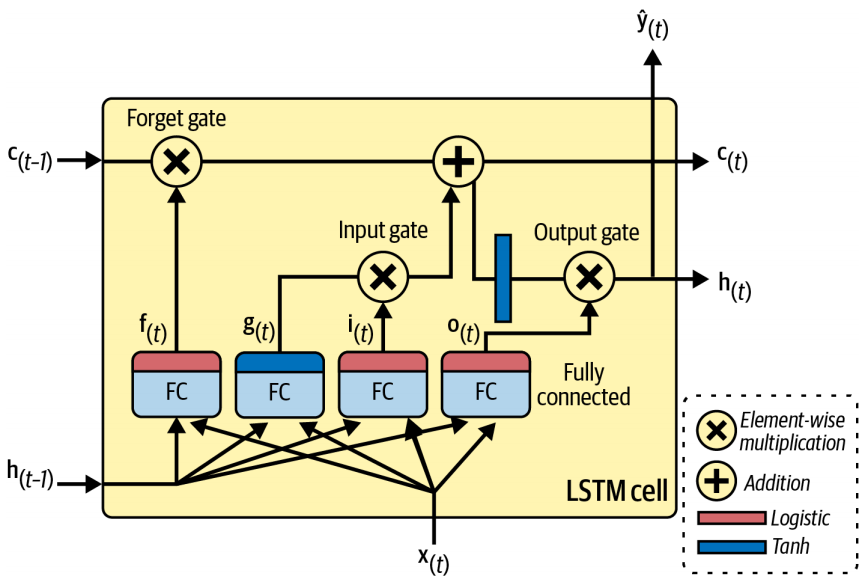

如果你不看盒子里面的东西，LSTM 单元看起来就像一个普通单元，除了它的状态被分成两个向量：$\pmb{h}_{(t)}$ 和 $\pmb{c}_{(t)}$（“$c$”代表“cell” ). 您可以将 $\pmb{h}_{(t)}$ 视为短期状态，将 $\pmb{c}_{(t)}$ 视为长期状态。

现在让我们开箱吧！关键思想是网络可以学习在长期状态下存储什么，丢弃什么，以及从中读取什么。当长期状态 $\pmb{c}_{(t–1)}$ 从左到右遍历网络时，您可以看到它首先通过 **forget gate**，丢弃一些记忆，然后通过加法操作添加一些新记忆（添加由 **input gate** 选择的记忆）。结果 $\pmb{c}_{(t)}$ 直接发送出去，没有任何进一步的转换。因此，在每个 time step，都会删除一些记忆并添加一些记忆。而且，在加法运算之后，将长期状态复制并通过 tanh 函数，然后将结果通过 **output gate** 进行过滤。这会产生短期状态 $\pmb{h}_{(t)}$（等于此 time step 的单元输出 $\pmb{y}_{(t)}$）。现在让我们看看新记忆从何而来以及这些门是如何工作的。

首先，当前输入向量 $\pmb{x}_{(t)}$ 和之前的短期状态 $\pmb{h}_{(t–1)}$ 被送到四个不同的全连接层。它们都有不同的用途：

- 主层是输出 $\pmb{g}_{(t)}$ 的那个层。它通常的作用是分析当前输入 $\pmb{x}_{(t)}$ 和先前（短期）状态 $\pmb{h}_{(t-1)}$ 。在一个基本单元中，这个层除了该单元没有其他东西，它的输出直接输出到 $\pmb{y}_{(t)}$ 和 $\pmb{h}_{(t)}$。但是在 LSTM 单元格中，这一层的输出不会直接输出；相反，它最重要的部分被存储在长期状态下（其余部分被删除）。
- 其他三层是 **门控制器（gate controller）**。由于它们使用逻辑激活函数，输出范围从 0 到 1。如您所见，门控制器的输出被送到逐元素乘法运算：如果它们输出 0 ，则关闭门，如果输出 1 ，则打开门。具体来说：**forget gate**（由 $\pmb{f}_{(t)}$ 控制）控制长期状态的清除；**input gate**（由 $\pmb{i}_{(t)}$ 控制）控制应将 $\pmb{g}_{(t)}$ 的哪些部分添加到长期状态；最后，**output gate**（由 $\pmb{o}_{(t)}$ 控制）控制在此 time step 应读取和输出长期状态的哪个部分，包括 $\pmb{h}_{(t)}$ 和 $\pmb{y}_{(t)}$。

简而言之，LSTM 单元可以学习识别一个重要的输入（即 **input gate** 的作用），将其存储在长期状态下，在需要时保存它（这是 **forget gate** 的作用），并在需要时提取它。这就解释了为什么这些单元在捕捉时间序列、长文本、录音等长期模式方面非常成功。

如下公式总结如何计算单个实例的单元的长期状态、短期状态以及它在每个 time step 上的输出（整个小批量的方程非常相似）。

**LSTM 计算**：

$$ \pmb{i}_{(t)}=\sigma(\pmb{W}_{xi}^T\pmb{x}_{(t)}+\pmb{W}_{hi}^T\pmb{h}_{(t-1)}+\pmb{b}_i) \\
\pmb{f}_{(t)}=\sigma(\pmb{W}_{xf}^T\pmb{x}_{(t)}+\pmb{W}_{hf}^T\pmb{h}_{(t-1)}+\pmb{b}_f) \\
\pmb{o}_{(t)}=\sigma(\pmb{W}_{xo}^T\pmb{x}_{(t)}+\pmb{W}_{ho}^T\pmb{h}_{(t-1)}+\pmb{b}_o) \\
\pmb{g}_{(t)}=tanh(\pmb{W}_{xg}^T\pmb{x}_{(t)}+\pmb{W}_{hg}\pmb{h}_{(t-1)}+\pmb{b}_g) \\
\pmb{c}_{(t)}=\pmb{f}_{(t)}\otimes \pmb{c}_{(t-1)}+\pmb{i}_{(t)}\otimes\pmb{g}_{(t)} \\
\pmb{y}_{(t)}=\pmb{h}_{(t)}=\pmb{o}_{(t)}\otimes tanh(\pmb{c}_{(t)})
$$

其中：

- $\pmb{W}_{xi},\pmb{W}_{xf},\pmb{W}_{xo},\pmb{W}_{xg}$ 是四层中的每一层连接到输入向量的 $\pmb{x}_{(t)}$ 的权重矩阵。
- $\pmb{W}_{hi},\pmb{W}_{hf},\pmb{W}_{ho},\pmb{W}_{hg}$ 是四个层中的每一层的权重矩阵，用于它们与之前的短期状态 $\pmb{h}_{(t-1)}$ 的连接。
- $\pmb{b}_i,\pmb{b}_f,\pmb{b}_o,\pmb{b}_g$ 是四层的偏差项。注意，TensorFlow 将 $\pmb{b}_f$ 初始化为一个充满 1 的向量，而不是 0 。这可以防止在训练开始时忘记一切。

LSTM 单元有几个变体。一个特别流行的变体是 GRU 单元，我们现在来看看。

#### 4.2.2 GRU 单元（GRU cells）

**门控循环单元（gated recurrent unit，GRU）** 是 Kyunghyun Cho 等人在 2014 年的一篇论文中提出的，该论文也介绍了我们之前讨论过的编码器-解码器网络。

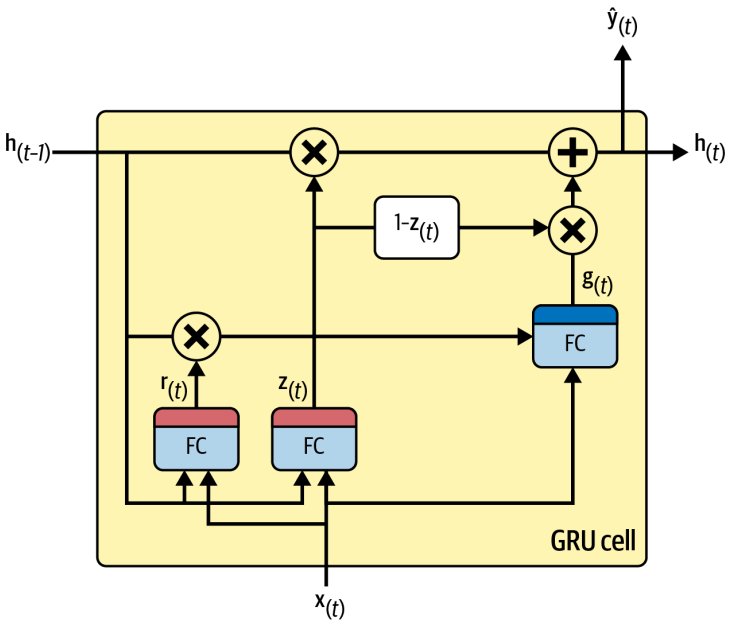

GRU 单元是 LSTM 单元的简化版本，它似乎表现得差不多（这也解释了它日益受欢迎的原因）。以下是主要的简化方法：

- 两个状态向量被合并为单个向量 $\pmb{h}_{(t)}$ 。
- 一个门控制器 $\pmb{z}_{(t)}$ 同时控制 **forget gate** 和 **input gate** 。如果门控制器输出 1 ，则 **forget gate** 打开（=1），**input gate** 关闭（1-1=0）。如果输出值为0，则正好相反。换句话说，每当必须存储记忆时，将首先删除要存储记忆位置中的内容。这实际上是 LSTM 单元本身的一种常见变体。
- 没有 **output gate** ；在每个 time step 中都输出全状态向量。然而，有一个新的门控制器 $\pmb{r}_{(t)}$ ，它控制先前状态将显示给主层（$\pmb{g}_{(t)}$）的那一部分。

如下公式总结了如何计算单个实例在每个 time step 上的单元状态。

**GRU 计算**：

$$ \pmb{z}_{(t)}=\sigma(\pmb{W}_{xz}^T\pmb{x}_{(t)}+\pmb{W}_{hz}^T\pmb{h}_{(t-1)}+\pmb{b}_z) \\
\pmb{r}_{(t)}=\sigma(\pmb{W}_{xr}^T\pmb{x}_{(t)}+\pmb{W}_{hr}^T\pmb{h}_{(t-1)}+\pmb{b}_r) \\
\pmb{g}_{(t)}=tanh(\pmb{W}_{xg}^T\pmb{x}_{(t)}+\pmb{W}_{hg}^T(\pmb{r}_{(t)}\otimes\pmb{h}_{(t-1)})+\pmb{b}_g) \\
\pmb{h}_{(t)}=\pmb{z}_{(t)}\otimes\pmb{h}_{(t-1)}+(1-\pmb{z}_{(t)})\otimes\pmb{g})_{(t)}
$$

Keras 提供了一个 **tf.keras.layers.GRU** 层：使用它只是用 GRU 替换 SimpleRNN 或 LSTM 。如果您想创建一个基于 GRU 单元的自定义单元，它还提供了一个 **tf.keras.layers.GRUCell**。

In [87]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [88]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 26ms/step - loss: 0.0682 - mae: 0.2822 - val_loss: 0.0206 - val_mae: 0.1632
Epoch 2/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0157 - mae: 0.1465 - val_loss: 0.0150 - val_mae: 0.1326
Epoch 3/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0127 - mae: 0.1319 - val_loss: 0.0135 - val_mae: 0.1250
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0115 - mae: 0.1239 - val_loss: 0.0123 - val_mae: 0.1209
Epoch 5/5
3/3 [==============================] - 0s 19ms/step - loss: 0.0116 - mae: 0.1167


116688.74323368073

LSTM 和 GRU 细胞是 RNN 成功的主要原因之一。然而，尽管它们可以处理比简单 RNN 更长的序列，但它们仍然有相当有限的短期记忆，而且它们很难在 100 个或更长 time step 的序列中学习长期模式，比如音频样本、长时间序列或长句子。解决这个问题的一种方法是缩短输入序列；例如，使用一维卷积层。

#### 4.2.3 使用一维卷积层来处理序列（Using 1D convolutional layers to process sequences）

在第 14 章中，我们看到 2D 卷积层通过在图像上滑动几个相当小的内核（或过滤器）来工作，生成多个 2D 特征图（每个内核一个）。类似地，一维卷积层在序列中滑动多个内核，为每个内核生成一个一维特征图。每个内核将学习检测单个非常短的序列模式（不长于内核大小）。如果您使用 10 个内核，则该层的输出将由 10 个 1D 序列（所有长度相同）组成，或者等效地，您可以将此输出视为单个 10D 序列。这意味着您可以构建一个由循环层和一维卷积层（甚至一维池化层）混合组成的神经网络。如果您使用步长为 1 且填充 `"same"` 的一维卷积层，则输出序列的长度将与输入序列的长度相同。但是，如果您使用 `"valid"` 填充或大于 1 的步幅，则输出序列将比输入序列短，因此请确保相应地调整目标。

例如，下面的模型与之前的模型相同，除了它以一维卷积层开始，该层使用 2 的步幅对输入序列进行 2 倍的下采样。内核大小大于步幅，因此所有输入都将 用于计算层的输出，因此模型可以学习保留有用的信息，仅丢弃不重要的细节。 通过缩短序列，卷积层可以帮助 GRU 层检测更长的模式，因此我们可以将输入序列长度加倍至 112 天。请注意，我们还必须裁掉目标中的前三个 time step：事实上，内核的大小为 4，因此卷积层的第一个输出将基于输入 time step 0 到 3，并且第一个预测将是对于 time step 4 到 17（而不是 time step 1 到 14）。此外，由于步幅，我们必须将目标下采样 2 倍：

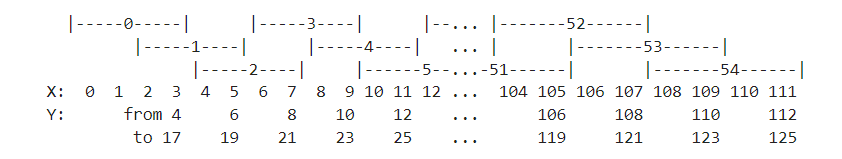

In [89]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)

longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)

downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))

downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

如果您训练和评估这个模型，您会发现它的性能优于以前的模型（略有优势）。事实上，它实际上可以只使用一维卷积层，并完全删除循环层！

In [91]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 7s 31ms/step - loss: 0.0543 - mae: 0.2564 - val_loss: 0.0204 - val_mae: 0.1562
Epoch 2/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0158 - mae: 0.1495 - val_loss: 0.0160 - val_mae: 0.1403
Epoch 3/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0134 - mae: 0.1382 - val_loss: 0.0142 - val_mae: 0.1285
Epoch 4/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0117 - mae: 0.1267 - val_loss: 0.0124 - val_mae: 0.1185
Epoch 5/5
1/1 [==============================] - 0s 86ms/step - loss: 0.0107 - mae: 0.1098


109785.92187166214

#### 4.2.4 WaveNet

在 2016 年的一篇论文中，Aaron van den Oord 和其他 DeepMind 研究人员介绍了一种名为 WaveNet 的新颖架构。他们堆叠了一维卷积层，使每一层的扩张率（每个神经元的输入如何分散）加倍：第一个卷积层一次只看到两个 time step，而下一个看到四个 time step（它的接收字段有四个 time step），下一个字段有八个 time step，依此类推。这样，较低层学习短期模式，而较高层学习长期模式。由于加倍的扩张率，网络可以非常有效地处理非常大的序列。

该论文的作者实际上堆叠了 10 个卷积层，其扩张率为 1、2、4、8、...、256、512，然后他们堆叠了另一组 10 个相同的层（同样具有扩张率 1、2、4、8， …, 256, 512)，然后又是另一组相同的 10 层。他们通过指出具有这些膨胀率的 10 个卷积层的单个堆栈将充当一个超高效的卷积层，其内核大小为 1024（除了更快、更强大还使用更少的参数），从而证明了这种架构。他们还在每一层之前用等于扩张率的零填充输入序列，以在整个网络中保持相同的序列长度。

下面是如何实现一个简化的 WaveNet 来处理与前面相同的序列：

In [92]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

wavenet_model = tf.keras.Sequential()

wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))

for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))

wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

这个 **Sequential** 模型从一个显式输入层开始——这比尝试仅在第一层设置 **input_shape** 更简单。 然后它继续使用 `"causal"` 填充的一维卷积层，这类似于 `"same"` 填充，只是零仅附加在输入序列的开头，而不是两侧。这确保了卷积层在进行预测时不会窥视未来。然后我们使用不断增长的扩张率添加相似的层对：1、2、4、8，然后再次是 1、2、4、8。最后，我们添加输出层：一个卷积层，有 14 个大小为 1 的过滤器，没有任何激活函数。正如我们之前看到的，这样的卷积层相当于一个有 14 个单元的 **Dense** 层。由于因果填充，每个卷积层输出一个与其输入序列长度相同的序列，因此我们在训练期间使用的目标可以是完整的 112 天序列：无需裁剪或下采样。

我们在本节中讨论的模型为客流量预测任务提供了类似的性能，但它们可能会因任务和可用数据量的不同而有很大差异。在 WaveNet 论文中，作者在各种音频任务（该架构的名称由此而来）上实现了最先进的性能，包括文本到语音任务，在多种语言中产生了令人难以置信的逼真声音。他们还使用该模型生成音乐，一次生成一个音频样本。当您意识到一秒钟的音频可以包含数万个 time step 时，这一壮举就更加令人印象深刻——即使 LSTM 和 GRU 也无法处理如此长的序列。

**注意**：如果您在 2020 年开始的测试期间评估我们最好的芝加哥乘客模型，您会发现它们的表现比预期差得多！这是为什么？好吧，那是 Covid-19 大流行开始的时候，它极大地影响了公共交通。如前所述，这些模型只有在他们从过去学到的模式在未来继续存在的情况下才会有效。无论如何，在将模型部署到生产环境之前，请验证它是否适用于最近的数据。一旦投入生产，请确保定期监控其性能。

有了它，你现在就可以处理各种时间序列了！在第 16 章中，我们将继续探索 RNNs ，同时我们还将看到它们如何处理各种 NLP 任务。